# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [0]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model


#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (-0.5)*euclidean(individual.reshape(1,self.imsize)-self.img.reshape(1,self.imsize))/self.imsize

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop) # softmax layer 
model = Model(inputs=[inp], outputs=[predictions])
model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
model.load_weights('CNN_MNIST.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5899

# Prepare Data

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
#def prepare_data(X,y):
 # X = X.reshape((X.shape[0], -1))
 # X_sc = X / 255.0
 # y_cat = to_categorical(y)
 # return X_sc, y_cat

In [0]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_sc = X_train / 255.0
y_cat = to_categorical(y_train)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test_sc = X_test / 255.0
y_pred_test = model.predict(np.expand_dims(X_test_sc.reshape(X_test_sc.shape[0],28,28),axis=3))
y_pred_train = model.predict(np.expand_dims(X_sc.reshape(X_sc.shape[0],28,28),axis=3))
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.9942333333333333
Test accuracy:  0.9907


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,28,1,5,10,10000)

In [0]:
subsample.shape

(1021, 784)

In [0]:
subsample_y.shape

(1021,)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(np.expand_dims(subsample_sc.reshape(subsample_sc.shape[0],28,28),axis=3))

In [0]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.9892262487757101


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)

In [0]:
original.shape

(895, 784)

In [0]:
adversarial.shape

(126, 784)

In [0]:
adversarial_y.shape

(126,)

In [0]:
import pickle
file_ = open('subset', 'wb')
pickle.dump(original, file_)
pickle.dump(adversarial, file_)
pickle.dump(original_y, file_)
pickle.dump(adversarial_y, file_)
file_.close()


# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 100, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  -1.110344972406137 25
50  :  -0.8824458609315691 25
75  :  -0.8588714473467327 25
100  :  -0.8588714473467327 25
125  :  -0.8588714473467327 25
150  :  -0.8588714473467327 25
175  :  -0.8588714473467327 25
200  :  -0.8588714473467327 25
225  :  -0.8287157403441165 25
250  :  -0.7897104303681015 25
275  :  -0.7950595193713756 25
300  :  -0.794766197858094 25
325  :  -0.7779933800224867 25
350  :  -0.7650807210842587 25
375  :  -0.7365340066226895 25
400  :  -0.7351280338538242 25
425  :  -0.6912771267365934 25
450  :  -0.6844964905416129 25
475  :  -0.6664126508362436 25
500  :  -0.6664126508362436 25
525  :  -0.6664126508362436 25
550  :  -0.6664126508362436 25
575  :  -0.6664126508362436 25
600  :  -0.6611113047014632 25
625  :  -0.6609965292437794 25
650  :  -0.6599369965902162 25
675  :  -0.655240327221515 25
700  :  -0.6497754491923267 25
725  :  -0.6485001240382335 25
750  :  -0.6453264160662786 25
775  :  -0.6435553461836465 25
800  :  -0.6387237838858819 25
825  :  -0.635

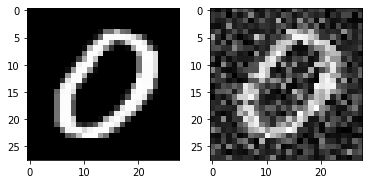

25  :  -1.4079400593434541 25
50  :  -1.4079400593434541 25
75  :  -1.4988813226685327 25
100  :  -1.4988813226685327 25
125  :  -1.4988813226685327 25
150  :  -1.4988813226685327 25
175  :  -1.3013357297051034 25
200  :  -0.955154407934284 25
225  :  -0.955154407934284 25
250  :  -0.955154407934284 25
275  :  -0.955154407934284 25
300  :  -0.8075744577393407 25
325  :  -0.7777808969286695 25
350  :  -0.7777808969286695 25
375  :  -0.7777808969286695 25
400  :  -0.7777808969286695 25
425  :  -0.7777808969286695 25
450  :  -0.7777808969286695 25
475  :  -0.7777808969286695 25
500  :  -0.7777808969286695 25
525  :  -0.7659698649091471 25
550  :  -0.7650360151202986 25
575  :  -0.7650360151202986 25
600  :  -0.7650360151202986 25
625  :  -0.7650360151202986 25
650  :  -0.7650360151202986 25
675  :  -0.7650360151202986 25
700  :  -0.7650360151202986 25
725  :  -0.7650360151202986 25
750  :  -0.7503024793244399 25
775  :  -0.7503024793244399 25
800  :  -0.7503024793244399 25
825  :  -0.7503

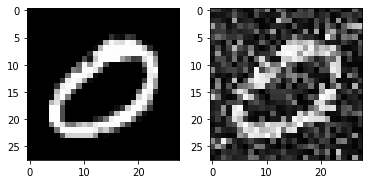

25  :  -1.6955981090211103 25
50  :  -1.5763762803776518 25
75  :  -1.5763762803776518 25
100  :  -1.5166037851392207 25
125  :  -1.4848912309960913 25
150  :  -1.4511021087869649 25
175  :  -1.4400369448243144 25
200  :  -1.4363226026695246 25
225  :  -1.4336285170243137 25
250  :  -1.3911645725701836 25
275  :  -1.3801666144952986 25
300  :  -1.3775108028261802 25
325  :  -1.3650929524724709 25
350  :  -1.365073285561909 25
375  :  -1.3584408646037192 25
400  :  -1.3422615207469444 25
425  :  -1.3358411017119007 25
450  :  -1.3345656454394448 25
475  :  -1.3151957781812875 25
500  :  -1.3151957781812875 25
525  :  -1.3151957781812875 25
550  :  -1.3119208600438423 25
575  :  -1.3117202968696997 25
600  :  -1.3003731039822113 25
625  :  -1.3003731039822113 25
650  :  -1.3003731039822113 25
675  :  -1.30009368759605 25
700  :  -1.2978403781236647 25
725  :  -1.2870477763314605 25
750  :  -1.2870477763314605 25
775  :  -1.283292278159784 25
800  :  -1.283292278159784 25
825  :  -1.28017

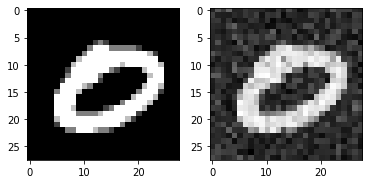

25  :  -1.0169688891516442 25
50  :  -1.0020224334822934 25
75  :  -1.0053766318982496 25
100  :  -0.9115380431410953 25
125  :  -0.9218313067591464 25
150  :  -0.9218313067591464 25
175  :  -0.9218313067591464 25
200  :  -0.8329458452882423 25
225  :  -0.7797090839759495 25
250  :  -0.841913309636181 25
275  :  -0.808493876567564 25
300  :  -0.7970457768706489 25
325  :  -0.7593708810117794 25
350  :  -0.7593708810117794 25
375  :  -0.7593708810117794 25
400  :  -0.7593708810117794 25
425  :  -0.737259821664078 25
450  :  -0.7252166230353303 25
475  :  -0.7170834055133681 25
500  :  -0.7170834055133681 25
525  :  -0.7170834055133681 25
550  :  -0.7170834055133681 25
575  :  -0.6983226371256843 25
600  :  -0.6983226371256843 25
625  :  -0.6889325709236032 25
650  :  -0.6889325709236032 25
675  :  -0.68605458573305 25
700  :  -0.6827056756494256 25
725  :  -0.6827056756494256 25
750  :  -0.6802600201951718 25
775  :  -0.680256748824533 25
800  :  -0.6792261219710514 25
825  :  -0.678146

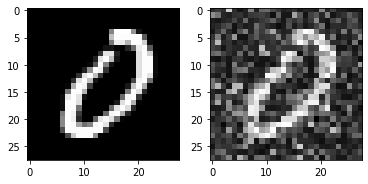

25  :  -0.7928813186732913 25
50  :  -0.7928813186732913 25
75  :  -0.7928813186732913 25
100  :  -0.7928813186732913 25
125  :  -0.7861156393574056 25
150  :  -0.7852642925644979 25
175  :  -0.7852642925644979 25
200  :  -0.7852642925644979 25
225  :  -0.7400577094311471 25
250  :  -0.6659656742763889 25
275  :  -0.6593615362942502 25
300  :  -0.6593615362942502 25
325  :  -0.6593615362942502 25
350  :  -0.613946666256959 25
375  :  -0.613946666256959 25
400  :  -0.613946666256959 25
425  :  -0.613946666256959 25
450  :  -0.613946666256959 25
475  :  -0.6075909096689398 25
500  :  -0.6075909096689398 25
525  :  -0.5845774108307105 25
550  :  -0.5847204216761017 25
575  :  -0.5847204216761017 25
600  :  -0.5847204216761017 25
625  :  -0.5828877368224539 25
650  :  -0.5828877368224539 25
675  :  -0.575151905534153 25
700  :  -0.575151905534153 25
725  :  -0.575151905534153 25
750  :  -0.570764780728225 25
775  :  -0.5670636922070043 25
800  :  -0.5625712002039318 25
825  :  -0.562426626

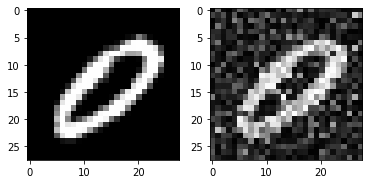

25  :  -0.7344231426407797 25
50  :  -0.7344231426407797 25
75  :  -0.7319312945765784 25
100  :  -0.7320331946182814 25
125  :  -0.7320331946182814 25
150  :  -0.7320331946182814 25
175  :  -0.7320331946182814 25
200  :  -0.7312157510574886 25
225  :  -0.7312157510574886 25
250  :  -0.7253917260271159 25
275  :  -0.7253917260271159 25
300  :  -0.7253917260271159 25
325  :  -0.7168106989886982 25
350  :  -0.6855081290129925 25
375  :  -0.6855081290129925 25
400  :  -0.6855081290129925 25
425  :  -0.6528511359360825 25
450  :  -0.6498574181029053 25
475  :  -0.6487749248822168 25
500  :  -0.6487749248822168 25
525  :  -0.6324741629088624 25
550  :  -0.6102920916712944 25
575  :  -0.6106359499044534 25
600  :  -0.6106359499044534 25
625  :  -0.6106359499044534 25
650  :  -0.6106359499044534 25
675  :  -0.5850708636306947 25
700  :  -0.5850708636306947 25
725  :  -0.5758900181891693 25
750  :  -0.5614880679573904 25
775  :  -0.5620776243405963 25
800  :  -0.5620776243405963 25
825  :  -0.

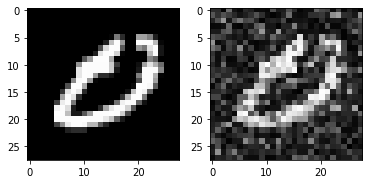

25  :  -1.6112840367756138 25
50  :  -1.6056976925219666 25
75  :  -1.322212640306983 25
100  :  -1.3089110735782947 25
125  :  -1.3089110735782947 25
150  :  -1.189898817183219 25
175  :  -1.3008393591133096 25
200  :  -1.1179867543724409 25
225  :  -1.0555970495689906 25
250  :  -1.0633194249873996 25
275  :  -1.0411707886462365 25
300  :  -1.0332492939956825 25
325  :  -1.0332492939956825 25
350  :  -0.8467913956245285 25
375  :  -0.8371013723720491 25
400  :  -0.8371013723720491 25
425  :  -0.8371013723720491 25
450  :  -0.8371013723720491 25
475  :  -0.8371013723720491 25
500  :  -0.8371013723720491 25
525  :  -0.8371013723720491 25
550  :  -0.7902650854054696 25
575  :  -0.7894547726323122 25
600  :  -0.7894547726323122 25
625  :  -0.7787289980515553 25
650  :  -0.7778325444736947 25
675  :  -0.7417788470096358 25
700  :  -0.7414961303334207 25
725  :  -0.7271969957765869 25
750  :  -0.7129704990570529 25
775  :  -0.7129704990570529 25
800  :  -0.7129704990570529 25
825  :  -0.70

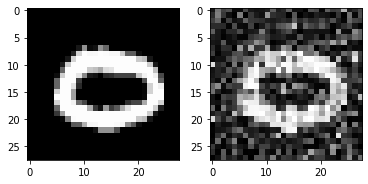

25  :  -0.87646673427121 25
50  :  -0.87646673427121 25
75  :  -0.8516218723667399 25
100  :  -0.7987389982603179 25
125  :  -0.785457860512849 25
150  :  -0.78496576749881 25
175  :  -0.78496576749881 25
200  :  -0.7083671546366272 25
225  :  -0.7166328043832271 25
250  :  -0.7166328043832271 25
275  :  -0.7166328043832271 25
300  :  -0.7166328043832271 25
325  :  -0.7166328043832271 25
350  :  -0.7166328043832271 25
375  :  -0.7166328043832271 25
400  :  -0.7166328043832271 25
425  :  -0.7070162937097784 25
450  :  -0.6910405293760664 25
475  :  -0.6910405293760664 25
500  :  -0.680240387868037 25
525  :  -0.6820033672961767 25
550  :  -0.6820033672961767 25
575  :  -0.6803800422968616 25
600  :  -0.6803800422968616 25
625  :  -0.6710044749100195 25
650  :  -0.6621721044567694 25
675  :  -0.6266492641215142 25
700  :  -0.625213745619319 25
725  :  -0.6100223736753658 25
750  :  -0.587191139542578 25
775  :  -0.587191139542578 25
800  :  -0.5829187952998591 25
825  :  -0.5821663251323

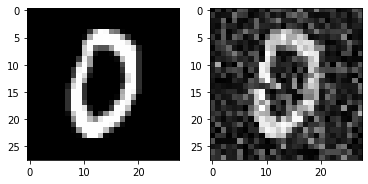

25  :  -0.7808987549732129 25
50  :  -0.7685199512969838 25
75  :  -0.7711658287077046 25
100  :  -0.7711658287077046 25
125  :  -0.7472583713824912 25
150  :  -0.7197592660158247 25
175  :  -0.7197592660158247 25
200  :  -0.7176296562943361 25
225  :  -0.6270217133534266 25
250  :  -0.6139801119245376 25
275  :  -0.6139801119245376 25
300  :  -0.6139801119245376 25
325  :  -0.6139801119245376 25
350  :  -0.5599248419067744 25
375  :  -0.5597779262846825 25
400  :  -0.5597779262846825 25
425  :  -0.5597779262846825 25
450  :  -0.5597779262846825 25
475  :  -0.5597779262846825 25
500  :  -0.559664803153709 25
525  :  -0.5481223379999196 25
550  :  -0.5251052225373372 25
575  :  -0.5243203640465346 25
600  :  -0.5227648026426185 25
625  :  -0.5216810890405152 25
650  :  -0.4995467855765877 25
675  :  -0.4957423913613377 25
700  :  -0.4957678319691774 25
725  :  -0.49368434891156676 25
750  :  -0.4938890127868192 25
775  :  -0.4892214662262969 25
800  :  -0.4892883109375519 25
825  :  -0.

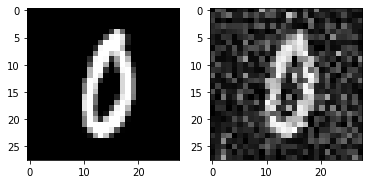

25  :  -1.2293299829997988 25
50  :  -1.1035355605039232 25
75  :  -1.1451612189059868 25
100  :  -1.1451612189059868 25
125  :  -0.9825693964228785 25
150  :  -0.9555999161466315 25
175  :  -0.9807070467746701 25
200  :  -0.9807070467746701 25
225  :  -0.9807070467746701 25
250  :  -0.9659874973229203 25
275  :  -0.9659874973229203 25
300  :  -0.9659874973229203 25
325  :  -0.9262316126790711 25
350  :  -0.9304044873626156 25
375  :  -0.9304044873626156 25
400  :  -0.9304044873626156 25
425  :  -0.9304044873626156 25
450  :  -0.9192158699716249 25
475  :  -0.9194815260630471 25
500  :  -0.8854715073213708 25
525  :  -0.8846587495150808 25
550  :  -0.8846587495150808 25
575  :  -0.8657477703307468 25
600  :  -0.8657477703307468 25
625  :  -0.8453173926309914 25
650  :  -0.8442310001318036 25
675  :  -0.8240998671739104 25
700  :  -0.8057549211292905 25
725  :  -0.7882304344789866 25
750  :  -0.7505163341865893 25
775  :  -0.7506891660649586 25
800  :  -0.7506891660649586 25
825  :  -0.

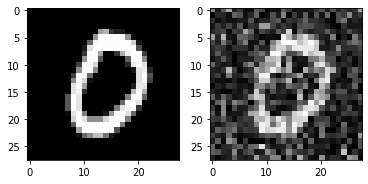

25  :  -0.820211027821482 25
50  :  -0.752770416700258 25
75  :  -0.7507796574712156 25
100  :  -0.7507796574712156 25
125  :  -0.7507796574712156 25
150  :  -0.7299380681362739 25
175  :  -0.7071727486225425 25
200  :  -0.6599629296761429 25
225  :  -0.6599629296761429 25
250  :  -0.6599629296761429 25
275  :  -0.6599629296761429 25
300  :  -0.6592663914805954 25
325  :  -0.6583456492300599 25
350  :  -0.6405002660303369 25
375  :  -0.6251634178812497 25
400  :  -0.6251634178812497 25
425  :  -0.6251634178812497 25
450  :  -0.6169973324561375 25
475  :  -0.6075116808126972 25
500  :  -0.5942255773594647 25
525  :  -0.59281644925208 25
550  :  -0.5820695453568141 25
575  :  -0.5661857454799386 25
600  :  -0.5547757904618709 25
625  :  -0.5539187129683671 25
650  :  -0.551046705690208 25
675  :  -0.551046705690208 25
700  :  -0.5502112744073142 25
725  :  -0.5456691754597778 25
750  :  -0.5448468479304098 25
775  :  -0.5439694385099436 25
800  :  -0.5439408536201167 25
825  :  -0.543886

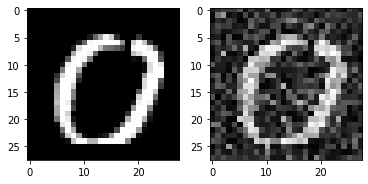

25  :  -1.6289405355625264 25
50  :  -1.2800389326654669 25
75  :  -1.107054350533782 25
100  :  -1.107054350533782 25
125  :  -1.0602341291442645 25
150  :  -1.0629035489130276 25
175  :  -1.0629035489130276 25
200  :  -1.0607719384084164 25
225  :  -0.966471878450528 25
250  :  -0.966471878450528 25
275  :  -0.9249504409715921 25
300  :  -0.9435666156533351 25
325  :  -0.9280765670020887 25
350  :  -0.9251676769071766 25
375  :  -0.9110283546521394 25
400  :  -0.9110283546521394 25
425  :  -0.9010105390592478 25
450  :  -0.8864423159800947 25
475  :  -0.8864423159800947 25
500  :  -0.8758974976201017 25
525  :  -0.8112128524153901 25
550  :  -0.8048547704373792 25
575  :  -0.8017218041167768 25
600  :  -0.8017218041167768 25
625  :  -0.8017218041167768 25
650  :  -0.8017218041167768 25
675  :  -0.7895496431944506 25
700  :  -0.7896377300509403 25
725  :  -0.7849983320363636 25
750  :  -0.773056955567387 25
775  :  -0.7737885734898013 25
800  :  -0.7737885734898013 25
825  :  -0.76255

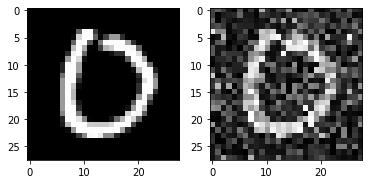

25  :  -0.6022315596140233 25
50  :  -0.6022315596140233 25
75  :  -0.5493377447279459 25
100  :  -0.5493377447279459 25
125  :  -0.5265151596023244 25
150  :  -0.502084105877898 25
175  :  -0.5021666433825339 25
200  :  -0.5021666433825339 25
225  :  -0.46003811121017624 25
250  :  -0.46003811121017624 25
275  :  -0.4255494268340839 25
300  :  -0.4110718296830016 25
325  :  -0.4110718296830016 25
350  :  -0.4110718296830016 25
375  :  -0.39760917085405934 25
400  :  -0.39760917085405934 25
425  :  -0.39323219910508334 25
450  :  -0.3928387628284066 25
475  :  -0.3911268854684088 25
500  :  -0.3905550820353564 25
525  :  -0.38807078023489006 25
550  :  -0.3850238150919366 25
575  :  -0.37741942737484724 25
600  :  -0.37741942737484724 25
625  :  -0.37445654984830046 25
650  :  -0.3744476449300572 25
675  :  -0.3722931936318634 25
700  :  -0.37081216771685477 25
725  :  -0.37081216771685477 25
750  :  -0.3702230931287076 25
775  :  -0.36936943794152055 25
800  :  -0.36835373573181507 25

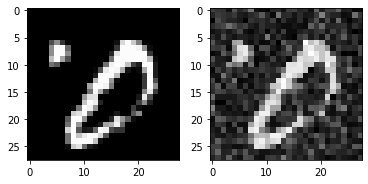

25  :  -0.6472948687358355 25
50  :  -0.618685892917241 25
75  :  -0.575710498467008 25
100  :  -0.5443399344981983 25
125  :  -0.5178693753394412 25
150  :  -0.5279488272634436 25
175  :  -0.5279488272634436 25
200  :  -0.5245989790907828 25
225  :  -0.5215110650960251 25
250  :  -0.5137550665509876 25
275  :  -0.5023108832059098 25
300  :  -0.48302259275834736 25
325  :  -0.47998815395075856 25
350  :  -0.4766740142910255 25
375  :  -0.45680064766720496 25
400  :  -0.4574245938632767 25
425  :  -0.4574245938632767 25
450  :  -0.4574245938632767 25
475  :  -0.4574245938632767 25
500  :  -0.4574245938632767 25
525  :  -0.45447710470781966 25
550  :  -0.44899111047722284 25
575  :  -0.44629151788968957 25
600  :  -0.4462402566091326 25
625  :  -0.4329433121419314 25
650  :  -0.4318783636331973 25
675  :  -0.42690964926269825 25
700  :  -0.42690964926269825 25
725  :  -0.42680119218084467 25
750  :  -0.4230382295056784 25
775  :  -0.4175010723274749 25
800  :  -0.4178997254600768 25
825 

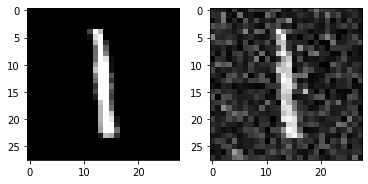

25  :  -0.707174809290422 25
50  :  -0.707174809290422 25
75  :  -0.6962910530695181 25
100  :  -0.6967360687191282 25
125  :  -0.6178463406168222 25
150  :  -0.6144939709165331 25
175  :  -0.6160321088214595 25
200  :  -0.6113302915975636 25
225  :  -0.6113302915975636 25
250  :  -0.6113302915975636 25
275  :  -0.6113302915975636 25
300  :  -0.6106457731625721 25
325  :  -0.5886232771809681 25
350  :  -0.5886232771809681 25
375  :  -0.5886232771809681 25
400  :  -0.5886232771809681 25
425  :  -0.5628886248861364 25
450  :  -0.5651470807182544 25
475  :  -0.5651470807182544 25
500  :  -0.5554046901110545 25
525  :  -0.5554046901110545 25
550  :  -0.5554046901110545 25
575  :  -0.5554046901110545 25
600  :  -0.5259260719590715 25
625  :  -0.5258850774130137 25
650  :  -0.5229724408177634 25
675  :  -0.5213327767453466 25
700  :  -0.5014808137331416 25
725  :  -0.501454565115537 25
750  :  -0.4888924395460388 25
775  :  -0.4888924395460388 25
800  :  -0.4829462811519125 25
825  :  -0.482

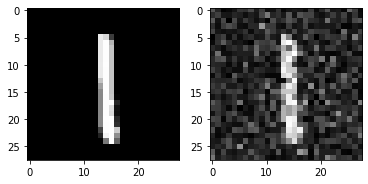

25  :  -0.7267816180376001 25
50  :  -0.7267816180376001 25
75  :  -0.7052387068047861 25
100  :  -0.6611938750362172 25
125  :  -0.6527495850257061 25
150  :  -0.6445785440920604 25
175  :  -0.6039175387558036 25
200  :  -0.603293935206584 25
225  :  -0.5709216542565556 25
250  :  -0.5541616382760473 25
275  :  -0.5426335137661191 25
300  :  -0.5421316855416731 25
325  :  -0.5390745573300944 25
350  :  -0.5390745573300944 25
375  :  -0.5390745573300944 25
400  :  -0.5390745573300944 25
425  :  -0.5344269846746184 25
450  :  -0.5337951085688697 25
475  :  -0.4994276068429945 25
500  :  -0.49946384621454043 25
525  :  -0.49946384621454043 25
550  :  -0.4877311394420474 25
575  :  -0.48621082899823964 25
600  :  -0.48621082899823964 25
625  :  -0.465880347839977 25
650  :  -0.46591981874710564 25
675  :  -0.46591981874710564 25
700  :  -0.46591981874710564 25
725  :  -0.46591981874710564 25
750  :  -0.45504479919906105 25
775  :  -0.45504479919906105 25
800  :  -0.45504479919906105 25
82

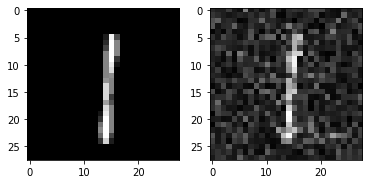

25  :  -0.7122027980549313 25
50  :  -0.7122027980549313 25
75  :  -0.6629334040968926 25
100  :  -0.6230855441195644 25
125  :  -0.6059584502861186 25
150  :  -0.5681742524113738 25
175  :  -0.5681742524113738 25
200  :  -0.5681742524113738 25
225  :  -0.5649771068916289 25
250  :  -0.5649771068916289 25
275  :  -0.5492019359515095 25
300  :  -0.5452581423144296 25
325  :  -0.5250510643863646 25
350  :  -0.5148495092902549 25
375  :  -0.5148495092902549 25
400  :  -0.5148495092902549 25
425  :  -0.5102403012696008 25
450  :  -0.5051525208691874 25
475  :  -0.5054083953839403 25
500  :  -0.502506836740109 25
525  :  -0.4971986900106866 25
550  :  -0.49208436306821646 25
575  :  -0.4826340832030749 25
600  :  -0.48103219396910124 25
625  :  -0.47950781766270456 25
650  :  -0.4729960821639191 25
675  :  -0.4681322333450134 25
700  :  -0.459677717831561 25
725  :  -0.45970796958495963 25
750  :  -0.45970796958495963 25
775  :  -0.4576799471436993 25
800  :  -0.45528134098151707 25
825  : 

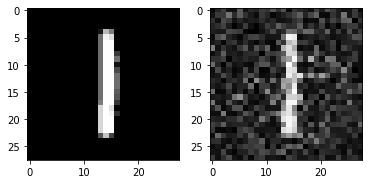

25  :  -0.68031441284287 25
50  :  -0.6523844929040905 25
75  :  -0.6091834751330674 25
100  :  -0.5786424091271749 25
125  :  -0.5743965196734309 25
150  :  -0.5715081120087775 25
175  :  -0.5637642138292334 25
200  :  -0.5274325935423494 25
225  :  -0.5194440102827307 25
250  :  -0.5194440102827307 25
275  :  -0.514125385261331 25
300  :  -0.5139889571931733 25
325  :  -0.5139889571931733 25
350  :  -0.48144711007441177 25
375  :  -0.4840576759659029 25
400  :  -0.4840576759659029 25
425  :  -0.4840576759659029 25
450  :  -0.4840576759659029 25
475  :  -0.4840576759659029 25
500  :  -0.48063321460106223 25
525  :  -0.4740593392098684 25
550  :  -0.4733763207790811 25
575  :  -0.47103714849346034 25
600  :  -0.4662724623815 25
625  :  -0.45595189363283983 25
650  :  -0.45709740195013815 25
675  :  -0.45709740195013815 25
700  :  -0.4492954069195453 25
725  :  -0.4492954069195453 25
750  :  -0.4492954069195453 25
775  :  -0.4427844803212948 25
800  :  -0.44282691274377295 25
825  :  -0

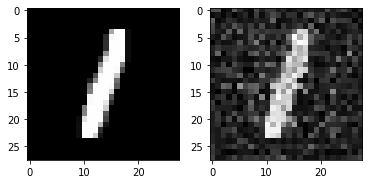

25  :  -0.6508899824005168 25
50  :  -0.6508899824005168 25
75  :  -0.5734707792949216 25
100  :  -0.5734707792949216 25
125  :  -0.5252612503081964 25
150  :  -0.5100688329001073 25
175  :  -0.5049178120259523 25
200  :  -0.5049178120259523 25
225  :  -0.4905439003940496 25
250  :  -0.4638330906025162 25
275  :  -0.4638330906025162 25
300  :  -0.4495370244266853 25
325  :  -0.44954429435766996 25
350  :  -0.44954429435766996 25
375  :  -0.4414756616033306 25
400  :  -0.4414756616033306 25
425  :  -0.43845121457292713 25
450  :  -0.4228262946238047 25
475  :  -0.4102623639451659 25
500  :  -0.40505689051936145 25
525  :  -0.40484594389134554 25
550  :  -0.39377823161974523 25
575  :  -0.39377823161974523 25
600  :  -0.39377823161974523 25
625  :  -0.38454887347577704 25
650  :  -0.3748946934876404 25
675  :  -0.3748946934876404 25
700  :  -0.3748946934876404 25
725  :  -0.36697547643892126 25
750  :  -0.365260812450378 25
775  :  -0.3645317944401544 25
800  :  -0.36453330799139727 25
8

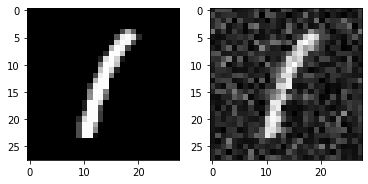

25  :  -0.7058829930094734 25
50  :  -0.6580018938363199 25
75  :  -0.6625848063088742 25
100  :  -0.6309710165251365 25
125  :  -0.6251116471699378 25
150  :  -0.5804701895823106 25
175  :  -0.5025653433279246 25
200  :  -0.5025653433279246 25
225  :  -0.5025653433279246 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


250  :  -0.5025653433279246 25
275  :  -0.5025653433279246 25
300  :  -0.4730176092599965 25
325  :  -0.47009630303466654 25
350  :  -0.46667793966537274 25
375  :  -0.45546130071489344 25
400  :  -0.44775060215696183 25
425  :  -0.44775060215696183 25
450  :  -0.44775060215696183 25
475  :  -0.4262304416621877 25
500  :  -0.42679025051705355 25
525  :  -0.41706979203940175 25
550  :  -0.41677577380934705 25
575  :  -0.41677577380934705 25
600  :  -0.41677577380934705 25
625  :  -0.3991152274063865 25
650  :  -0.3991166305179007 25
675  :  -0.3991166305179007 25
700  :  -0.3991166305179007 25
725  :  -0.3991166305179007 25
750  :  -0.38620535856857063 25
775  :  -0.3840625389284702 25
800  :  -0.3764738763043829 25
825  :  -0.3767254727200162 25
850  :  -0.3767254727200162 25
875  :  -0.37327980777071745 25
900  :  -0.36994860759537374 25
925  :  -0.36781876296921745 25
950  :  -0.36710709229716354 25
975  :  -0.3672368284972317 25
1000  :  -0.3653815583585224 25
1025  :  -0.3653815798

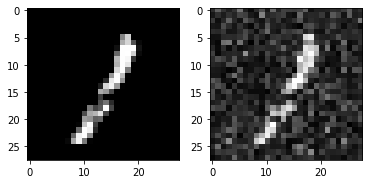

25  :  -0.6420298176457178 25
50  :  -0.6074073381238114 25
75  :  -0.6222689281071072 25
100  :  -0.5642186452041975 25
125  :  -0.5642186452041975 25
150  :  -0.5585586302857124 25
175  :  -0.5436851546380048 25
200  :  -0.5053652827049636 25
225  :  -0.5024050029207023 25
250  :  -0.4912223232018814 25
275  :  -0.48952577839397915 25
300  :  -0.48952577839397915 25
325  :  -0.47553276795349686 25
350  :  -0.47529037909916794 25
375  :  -0.4696528172961818 25
400  :  -0.4653171390734646 25
425  :  -0.4653171390734646 25
450  :  -0.4650298031120931 25
475  :  -0.46099673385304396 25
500  :  -0.4555334301908762 25
525  :  -0.4526540011824972 25
550  :  -0.43780078005958856 25
575  :  -0.42708751734272943 25
600  :  -0.42744586855052713 25
625  :  -0.4172903903818097 25
650  :  -0.41730780026904346 25
675  :  -0.41730780026904346 25
700  :  -0.41730780026904346 25
725  :  -0.41730780026904346 25
750  :  -0.4077721501884478 25
775  :  -0.4067059764180251 25
800  :  -0.39723085855187446 2

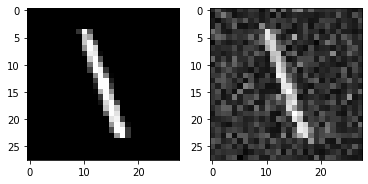

25  :  -0.654359933079897 25
50  :  -0.654359933079897 25
75  :  -0.6040719208600058 25
100  :  -0.6040719208600058 25
125  :  -0.5904536990016651 25
150  :  -0.5792528278501461 25
175  :  -0.5604729961091734 25
200  :  -0.5537252924718465 25
225  :  -0.5520996110639385 25
250  :  -0.5391987596965273 25
275  :  -0.4934077304490836 25
300  :  -0.4934077304490836 25
325  :  -0.4934077304490836 25
350  :  -0.4934077304490836 25
375  :  -0.4934077304490836 25
400  :  -0.4796040953602855 25
425  :  -0.47939765847903293 25
450  :  -0.47939765847903293 25
475  :  -0.47939765847903293 25
500  :  -0.47939765847903293 25
525  :  -0.4694229386725135 25
550  :  -0.46924762334748027 25
575  :  -0.4608853639413951 25
600  :  -0.457486123892897 25
625  :  -0.45756357302329764 25
650  :  -0.45756357302329764 25
675  :  -0.45756357302329764 25
700  :  -0.45756357302329764 25
725  :  -0.45756357302329764 25
750  :  -0.455169862132054 25
775  :  -0.45398297152813505 25
800  :  -0.448250379384201 25
825  

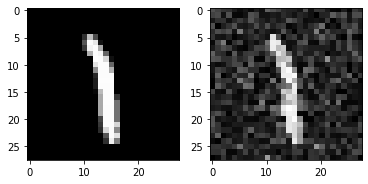

25  :  -0.6827756610460418 25
50  :  -0.6345243680900332 25
75  :  -0.6390334738744101 25
100  :  -0.6173417394288523 25
125  :  -0.5987794703517508 25
150  :  -0.5106768891961552 25
175  :  -0.5123812137477369 25
200  :  -0.5123812137477369 25
225  :  -0.5123812137477369 25
250  :  -0.5123812137477369 25
275  :  -0.5027121458017325 25
300  :  -0.49799312102199966 25
325  :  -0.49799312102199966 25
350  :  -0.49799312102199966 25
375  :  -0.45620059575870375 25
400  :  -0.45620059575870375 25
425  :  -0.45620059575870375 25
450  :  -0.44913873362943724 25
475  :  -0.4458666552715078 25
500  :  -0.44533870696208455 25
525  :  -0.4453223625853042 25
550  :  -0.4453223625853042 25
575  :  -0.4360796806091367 25
600  :  -0.4360796806091367 25
625  :  -0.4360796806091367 25
650  :  -0.43160486128735487 25
675  :  -0.4232969382512527 25
700  :  -0.4209243842035163 25
725  :  -0.4209243842035163 25
750  :  -0.4209243842035163 25
775  :  -0.40834029861408017 25
800  :  -0.4083646379392508 25
8

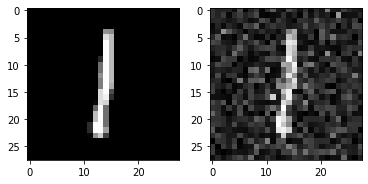

25  :  -0.7329448708762298 25
50  :  -0.6673349078104449 25
75  :  -0.6574060222115423 25
100  :  -0.5970384885060391 25
125  :  -0.5898696794046494 25
150  :  -0.5791976185478378 25
175  :  -0.576655223387605 25
200  :  -0.576655223387605 25
225  :  -0.576655223387605 25
250  :  -0.5688607829266406 25
275  :  -0.5652360084438737 25
300  :  -0.5719646386191601 25
325  :  -0.5139027213206865 25
350  :  -0.5139027213206865 25
375  :  -0.5075250541428324 25
400  :  -0.5047011466673998 25
425  :  -0.47772282572012525 25
450  :  -0.4781207018609569 25
475  :  -0.4781207018609569 25
500  :  -0.4781207018609569 25
525  :  -0.4680772050111448 25
550  :  -0.4680772050111448 25
575  :  -0.4680772050111448 25
600  :  -0.4680772050111448 25
625  :  -0.45420406865390683 25
650  :  -0.4535002000272522 25
675  :  -0.44726654805361743 25
700  :  -0.44685831295064904 25
725  :  -0.43227091554285124 25
750  :  -0.41022902376415216 25
775  :  -0.41022902376415216 25
800  :  -0.40651498258045626 25
825  :

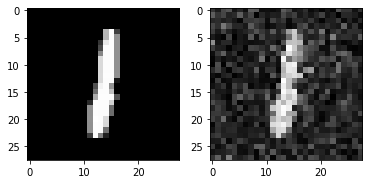

25  :  -0.6673920719858686 25
50  :  -0.5867625745529435 25
75  :  -0.5765368068145766 25
100  :  -0.5765368068145766 25
125  :  -0.5689762354752592 25
150  :  -0.5399687872366099 25
175  :  -0.5234360218572884 25
200  :  -0.5158174217055342 25
225  :  -0.48608384935906257 25
250  :  -0.48661823499006074 25
275  :  -0.485056210226656 25
300  :  -0.4581328071801891 25
325  :  -0.45040705725063757 25
350  :  -0.4448407995899937 25
375  :  -0.4446453305943977 25
400  :  -0.428487814382811 25
425  :  -0.4179002770170438 25
450  :  -0.4179002770170438 25
475  :  -0.4139908148120799 25
500  :  -0.40943155631240136 25
525  :  -0.4094685447810159 25
550  :  -0.4094685447810159 25
575  :  -0.40429485700828716 25
600  :  -0.40373810436518 25
625  :  -0.40001741152242176 25
650  :  -0.39877751288845353 25
675  :  -0.38993235862423326 25
700  :  -0.3900153892707915 25
725  :  -0.3900153892707915 25
750  :  -0.3900153892707915 25
775  :  -0.38781638157644904 25
800  :  -0.3863816243890146 25
825  :

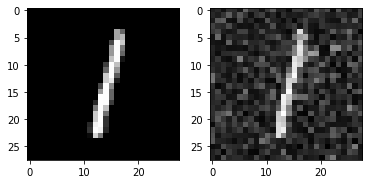

25  :  -0.6458524405513133 25
50  :  -0.6304015615093179 25
75  :  -0.6305703509694784 25
100  :  -0.6056268979163759 25
125  :  -0.5910353108876407 25
150  :  -0.5769100027737981 25
175  :  -0.5760763304322192 25
200  :  -0.5718119647026949 25
225  :  -0.5714633297459577 25
250  :  -0.5484729393228884 25
275  :  -0.5405550065674551 25
300  :  -0.5404829472084747 25
325  :  -0.5396970683402815 25
350  :  -0.5386431940873846 25
375  :  -0.5386431940873846 25
400  :  -0.5386431940873846 25
425  :  -0.5107704724077348 25
450  :  -0.5107704724077348 25
475  :  -0.5107704724077348 25
500  :  -0.5094941369412058 25
525  :  -0.5090111335089915 25
550  :  -0.5090111335089915 25
575  :  -0.5090111335089915 25
600  :  -0.5090111335089915 25
625  :  -0.5090111335089915 25
650  :  -0.5090111335089915 25
675  :  -0.48871463811883953 25
700  :  -0.48832425669669755 25
725  :  -0.48686462846197487 25
750  :  -0.48730410914305944 25
775  :  -0.48730410914305944 25
800  :  -0.48084207339847795 25
825  

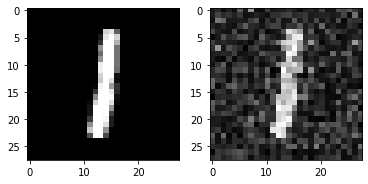

25  :  -0.686433150139514 25
50  :  -0.6372033988870756 25
75  :  -0.6261520630123776 25
100  :  -0.5871736749860401 25
125  :  -0.5476548827009426 25
150  :  -0.48118999193849943 25
175  :  -0.45601707345203013 25
200  :  -0.45601707345203013 25
225  :  -0.441960914782912 25
250  :  -0.4181846593566383 25
275  :  -0.4185846008263717 25
300  :  -0.40814532105919776 25
325  :  -0.4055255035523422 25
350  :  -0.4039019919210318 25
375  :  -0.38841035072751096 25
400  :  -0.38521550406096017 25
425  :  -0.3821910431838784 25
450  :  -0.38071265006269106 25
475  :  -0.37762915848601464 25
500  :  -0.37637203237526584 25
525  :  -0.37118861295701144 25
550  :  -0.36821284009923705 25
575  :  -0.36809110483539775 25
600  :  -0.3672317239028501 25
625  :  -0.36567378275990214 25
650  :  -0.362641366827933 25
675  :  -0.3611616637041859 25
700  :  -0.3606190923974446 25
725  :  -0.35959451124713393 25
750  :  -0.358590416206794 25
775  :  -0.358590416206794 25
800  :  -0.3575786384891235 25
82

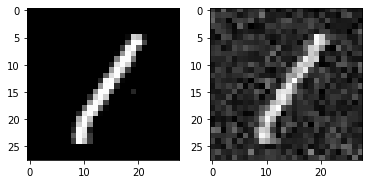

25  :  -0.6475052539486263 25
50  :  -0.5746940784199475 25
75  :  -0.5746940784199475 25
100  :  -0.5746940784199475 25
125  :  -0.5746940784199475 25
150  :  -0.5159950460643499 25
175  :  -0.5159950460643499 25
200  :  -0.5142699841477227 25
225  :  -0.4525271292847669 25
250  :  -0.4599101895558807 25
275  :  -0.4599101895558807 25
300  :  -0.4599101895558807 25
325  :  -0.4599101895558807 25
350  :  -0.4599101895558807 25
375  :  -0.4528176311714689 25
400  :  -0.4529393026736186 25
425  :  -0.4419440380432915 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


450  :  -0.43475692401358434 25
475  :  -0.43453068000900574 25
500  :  -0.427605969323158 25
525  :  -0.42754512691981095 25
550  :  -0.42754512691981095 25
575  :  -0.42754512691981095 25
600  :  -0.42754512691981095 25
625  :  -0.4238450528909563 25
650  :  -0.4152405527946802 25
675  :  -0.4152405527946802 25
700  :  -0.4152405527946802 25
725  :  -0.41112299584759326 25
750  :  -0.41107639759541426 25
775  :  -0.40882729597097645 25
800  :  -0.40490174122881073 25
825  :  -0.4052189821649088 25
850  :  -0.4052189821649088 25
875  :  -0.4052189821649088 25
900  :  -0.4052189821649088 25
925  :  -0.4047939034814172 25
950  :  -0.4035297167269324 25
975  :  -0.4022193018082456 25
1000  :  -0.39027765978510454 25
1025  :  -0.3905546828235954 25
1050  :  -0.3905546828235954 25
1075  :  -0.3905546828235954 25
1100  :  -0.38982818527316243 25
1125  :  -0.38982818527316243 25
1150  :  -0.38982818527316243 25
1175  :  -0.38824867721776113 25
1199  :  -0.3845238157330986 24
1223  :  -0.3795

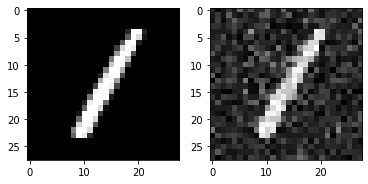

25  :  -1.6498395209358654 25
50  :  -1.6498395209358654 25
75  :  -1.5848838051658254 25
100  :  -1.5602713167785318 25
125  :  -1.4956770831898236 25
150  :  -1.4956770831898236 25
175  :  -1.4903126921382204 25
200  :  -1.4726654639463685 25
225  :  -1.428798341302338 25
250  :  -1.428798341302338 25
275  :  -1.428798341302338 25
300  :  -1.4025941140482892 25
325  :  -1.4025941140482892 25
350  :  -1.3897574762330211 25
375  :  -1.389756952764472 25
400  :  -1.389756952764472 25
425  :  -1.3829772640809037 25
450  :  -1.3829772640809037 25
475  :  -1.3673001009119496 25
500  :  -1.36048900366306 25
525  :  -1.36048900366306 25
550  :  -1.36048900366306 25
575  :  -1.36048900366306 25
600  :  -1.36048900366306 25
625  :  -1.36048900366306 25
650  :  -1.3517559697333144 25
675  :  -1.3517559697333144 25
700  :  -1.3487229119990407 25
725  :  -1.348226928988336 25
750  :  -1.3467146131445262 25
775  :  -1.3432340628092712 25
800  :  -1.3402818151668416 25
825  :  -1.340053958779724 25

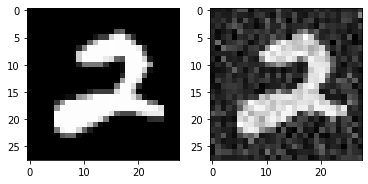

25  :  -1.6112976258204064 25
50  :  -1.4356034730925078 25
75  :  -1.4356034730925078 25
100  :  -1.4356034730925078 25
125  :  -1.4356034730925078 25
150  :  -1.4356034730925078 25
175  :  -1.4171635494732238 25
200  :  -1.4171635494732238 25
225  :  -1.4171635494732238 25
250  :  -1.3923713802747428 25
275  :  -1.3793313289776776 25
300  :  -1.3793313289776776 25
325  :  -1.3793313289776776 25
350  :  -1.343696279017296 25
375  :  -1.343696279017296 25
400  :  -1.343696279017296 25
425  :  -1.327269831024652 25
450  :  -1.3183175948609422 25
475  :  -1.3183144519862406 25
500  :  -1.3123442329459314 25
525  :  -1.3074190088396067 25
550  :  -1.3047585745218602 25
575  :  -1.2981924256035704 25
600  :  -1.2981366419373563 25
625  :  -1.29731598848335 25
650  :  -1.2892572939633506 25
675  :  -1.2892572939633506 25
700  :  -1.287079196076736 25
725  :  -1.287079196076736 25
750  :  -1.28497344012287 25
775  :  -1.282803257574817 25
800  :  -1.282803257574817 25
825  :  -1.278463784830

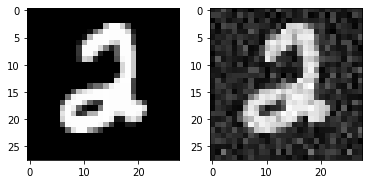

25  :  -1.5671716579459218 25
50  :  -1.5671716579459218 25
75  :  -1.5671716579459218 25
100  :  -1.4931508309814747 25
125  :  -1.4858025763680973 25
150  :  -1.485187204852706 25
175  :  -1.4454100244580383 25
200  :  -1.4454100244580383 25
225  :  -1.3969296667678557 25
250  :  -1.3969296667678557 25
275  :  -1.3965953798852686 25
300  :  -1.3965953798852686 25
325  :  -1.384068884091558 25
350  :  -1.384068884091558 25
375  :  -1.384068884091558 25
400  :  -1.3732901958277224 25
425  :  -1.3508263192361292 25
450  :  -1.3508263192361292 25
475  :  -1.3508263192361292 25
500  :  -1.3456436790930857 25
525  :  -1.3443457285126938 25
550  :  -1.3313311778455388 25
575  :  -1.3307794012342782 25
600  :  -1.3282815712132732 25
625  :  -1.3276052956783118 25
650  :  -1.3198887903057661 25
675  :  -1.3192611401660495 25
700  :  -1.3192611401660495 25
725  :  -1.3145818426155937 25
750  :  -1.314209326893522 25
775  :  -1.314209326893522 25
800  :  -1.3131871799637562 25
825  :  -1.312544

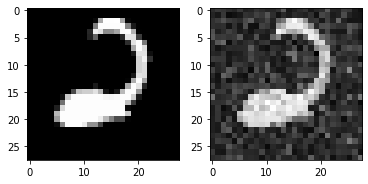

25  :  -1.1436222648928789 25
50  :  -0.9828740429697773 25
75  :  -0.915834780970527 25
100  :  -0.9113953846541301 25
125  :  -0.8631171657754446 25
150  :  -0.8631171657754446 25
175  :  -0.8631171657754446 25
200  :  -0.8187019537352533 25
225  :  -0.8201624134697558 25
250  :  -0.7614162389501538 25
275  :  -0.6986956108544358 25
300  :  -0.6986956108544358 25
325  :  -0.6986956108544358 25
350  :  -0.6932313065362028 25
375  :  -0.6734395694538859 25
400  :  -0.6782787311131377 25
425  :  -0.6731842487120288 25
450  :  -0.6618618682516895 25
475  :  -0.6541320243632198 25
500  :  -0.6472540238981843 25
525  :  -0.6472540238981843 25
550  :  -0.6391991912963029 25
575  :  -0.6287586279920319 25
600  :  -0.61843106348039 25
625  :  -0.6151228249859324 25
650  :  -0.6103107483773884 25
675  :  -0.6044070735717084 25
700  :  -0.6044720805277413 25
725  :  -0.6001784263836374 25
750  :  -0.6000259191255513 25
775  :  -0.5984459430152995 25
800  :  -0.5985098669593714 25
825  :  -0.597

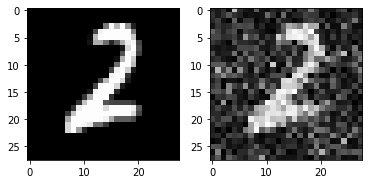

25  :  -1.4852168742179528 25
50  :  -1.3100777239318575 25
75  :  -1.0125127013960888 25
100  :  -1.0742729338391421 25
125  :  -0.8784000354431356 25
150  :  -0.872355291051564 25
175  :  -0.8883047810964175 25
200  :  -0.8710195702113868 25
225  :  -0.7851568709244914 25
250  :  -0.7851581758305355 25
275  :  -0.7851581758305355 25
300  :  -0.77578314215131 25
325  :  -0.77578314215131 25
350  :  -0.77578314215131 25
375  :  -0.7370145206660783 25
400  :  -0.7370145206660783 25
425  :  -0.7370145206660783 25
450  :  -0.7370145206660783 25
475  :  -0.7310079084338534 25
500  :  -0.7205005053987554 25
525  :  -0.7210964599177723 25
550  :  -0.716587075518146 25
575  :  -0.7133686537861754 25
600  :  -0.7112514306851057 25
625  :  -0.7037516535467374 25
650  :  -0.6886300749156355 25
675  :  -0.6882908879262022 25
700  :  -0.6882179817803042 25
725  :  -0.6841622542200716 25
750  :  -0.6841622542200716 25
775  :  -0.6834130478003817 25
800  :  -0.6805309876141088 25
825  :  -0.67900396

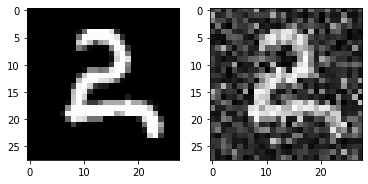

25  :  -1.0437469596369144 25
50  :  -1.030129147724641 25
75  :  -0.7767829962125763 25
100  :  -0.7767829962125763 25
125  :  -0.7767829962125763 25
150  :  -0.7767829962125763 25
175  :  -0.753004777258619 25
200  :  -0.7539330780199054 25
225  :  -0.7539330780199054 25
250  :  -0.7539330780199054 25
275  :  -0.7539330780199054 25
300  :  -0.7539330780199054 25
325  :  -0.7033140579097177 25
350  :  -0.7033140579097177 25
375  :  -0.7033140579097177 25
400  :  -0.6521397228187016 25
425  :  -0.6521397228187016 25
450  :  -0.6373251214627602 25
475  :  -0.6045000681603234 25
500  :  -0.6045000681603234 25
525  :  -0.6037226152056236 25
550  :  -0.5964001054419956 25
575  :  -0.5966444470998822 25
600  :  -0.5966444470998822 25
625  :  -0.5943437499171524 25
650  :  -0.5914793616192224 25
675  :  -0.5854374551332031 25
700  :  -0.5834212160190029 25
725  :  -0.5829980538880866 25
750  :  -0.5796594502316035 25
775  :  -0.5787487871147521 25
800  :  -0.5766476510384859 25
825  :  -0.57

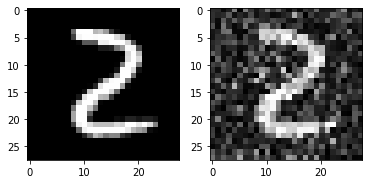

25  :  -0.9972966407104744 25
50  :  -0.9104730625766027 25
75  :  -0.8898776166907556 25
100  :  -0.8492648048039331 25
125  :  -0.8898776166907556 25
150  :  -0.8776129946159985 25
175  :  -0.8422843309510006 25
200  :  -0.7533185748627533 25
225  :  -0.7516019086184977 25
250  :  -0.7516019086184977 25
275  :  -0.7516019086184977 25
300  :  -0.7516019086184977 25
325  :  -0.7516019086184977 25
350  :  -0.7516019086184977 25
375  :  -0.7516019086184977 25
400  :  -0.7450518367017427 25
425  :  -0.7450518367017427 25
450  :  -0.7308838812351599 25
475  :  -0.6973159120136121 25
500  :  -0.6949302302020941 25
525  :  -0.6939274112077014 25
550  :  -0.6942134845056382 25
575  :  -0.6894160442199793 25
600  :  -0.6757447534435521 25
625  :  -0.6709806313444877 25
650  :  -0.666322339117772 25
675  :  -0.666322339117772 25
700  :  -0.666322339117772 25
725  :  -0.6648359347187964 25
750  :  -0.6616924950908885 25
775  :  -0.6592897325912139 25
800  :  -0.6569130906277438 25
825  :  -0.654

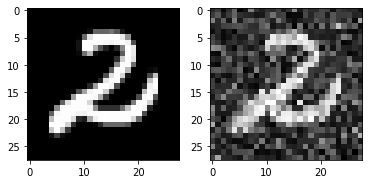

25  :  -0.8882074133050113 25
50  :  -0.8882074133050113 25
75  :  -1.0695927627630917 25
100  :  -0.9634247438052805 25
125  :  -0.9888527751645528 25
150  :  -0.9519264264356935 25
175  :  -0.9285609505904686 25
200  :  -0.9285609505904686 25
225  :  -0.8462979676372644 25
250  :  -0.9285609505904686 25
275  :  -0.9285609505904686 25
300  :  -0.8549515227951276 25
325  :  -0.8277976867841716 25
350  :  -0.8126945507882708 25
375  :  -0.8064110930839601 25
400  :  -0.8103002881142125 25
425  :  -0.7619337251566523 25
450  :  -0.7496562540373934 25
475  :  -0.7496562540373934 25
500  :  -0.7496562540373934 25
525  :  -0.7496562540373934 25
550  :  -0.7496562540373934 25
575  :  -0.7496562540373934 25
600  :  -0.7496562540373934 25
625  :  -0.7496562540373934 25
650  :  -0.7496562540373934 25
675  :  -0.7496562540373934 25
700  :  -0.7496562540373934 25
725  :  -0.7261402471215588 25
750  :  -0.7265205112908013 25
775  :  -0.7264815719769686 25
800  :  -0.7259133056680225 25
825  :  -0.

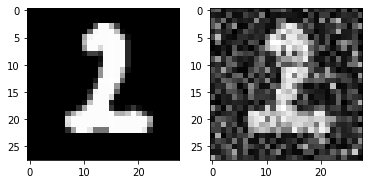

25  :  -1.5984109871795167 25
50  :  -1.5984109871795167 25
75  :  -1.3369623889843332 25
100  :  -1.1691868594768986 25
125  :  -1.2147560959857393 25
150  :  -0.990858673465818 25
175  :  -0.990858673465818 25
200  :  -0.900962403248732 25
225  :  -0.8664334959848305 25
250  :  -0.8729424942001369 25
275  :  -0.8729424942001369 25
300  :  -0.8729424942001369 25
325  :  -0.8729424942001369 25
350  :  -0.8729424942001369 25
375  :  -0.8729424942001369 25
400  :  -0.7471675891095038 25
425  :  -0.741738180466327 25
450  :  -0.741738180466327 25
475  :  -0.741738180466327 25
500  :  -0.741738180466327 25
525  :  -0.741738180466327 25
550  :  -0.7281071689846454 25
575  :  -0.6905908369134988 25
600  :  -0.6905908369134988 25
625  :  -0.6905908369134988 25
650  :  -0.6905908369134988 25
675  :  -0.6854591312479683 25
700  :  -0.6852747534331225 25
725  :  -0.6793611884204724 25
750  :  -0.6679607908857574 25
775  :  -0.6654895459799137 25
800  :  -0.6526430211670671 25
825  :  -0.64829264

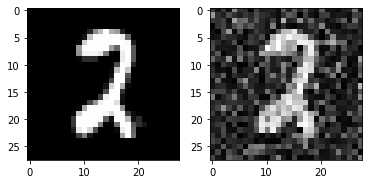

25  :  -1.6171075110946838 25
50  :  -1.6171075110946838 25
75  :  -1.538630130610733 25
100  :  -1.4650332275944646 25
125  :  -1.3552447830727408 25
150  :  -1.4021891952523435 25
175  :  -1.212398441948124 25
200  :  -1.0999195420790553 25
225  :  -1.063469499031317 25
250  :  -0.8217852333574709 25
275  :  -0.7490165611430579 25
300  :  -0.732931742613715 25
325  :  -0.732931742613715 25
350  :  -0.7169643297877197 25
375  :  -0.7169643297877197 25
400  :  -0.7169643297877197 25
425  :  -0.7169643297877197 25
450  :  -0.7169643297877197 25
475  :  -0.7169643297877197 25
500  :  -0.7110239152787821 25
525  :  -0.7117447261808474 25
550  :  -0.6764805570969274 25
575  :  -0.6780307968522323 25
600  :  -0.6647812206895605 25
625  :  -0.6655272052005283 25
650  :  -0.6588419590506884 25
675  :  -0.641878097872149 25
700  :  -0.6418129179474241 25
725  :  -0.6363235900014867 25
750  :  -0.6218380718094787 25
775  :  -0.6123625547490947 25
800  :  -0.6099855391482851 25
825  :  -0.606389

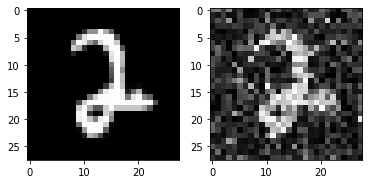

25  :  -1.093563895621518 25
50  :  -1.093563895621518 25
75  :  -1.0200337429151016 25
100  :  -0.9417826570197576 25
125  :  -0.7162721086936941 25
150  :  -0.8393889374253225 25
175  :  -0.824876076805761 25
200  :  -0.7748414092838618 25
225  :  -0.7709513247672388 25
250  :  -0.7165409279919972 25
275  :  -0.7165409279919972 25
300  :  -0.7165409279919972 25
325  :  -0.7165409279919972 25
350  :  -0.7165409279919972 25
375  :  -0.7165409279919972 25
400  :  -0.7165409279919972 25
425  :  -0.6836056406556232 25
450  :  -0.7016387018233752 25
475  :  -0.6732007062926093 25
500  :  -0.6695698235589902 25
525  :  -0.6517229511914056 25
550  :  -0.6354167822860237 25
575  :  -0.5909106911717246 25
600  :  -0.5895321568624246 25
625  :  -0.5895321568624246 25
650  :  -0.5895321568624246 25
675  :  -0.5849762432849992 25
700  :  -0.5849334615831969 25
725  :  -0.5849334615831969 25
750  :  -0.5839697073259682 25
775  :  -0.5837376101220002 25
800  :  -0.5834175079392909 25
825  :  -0.578

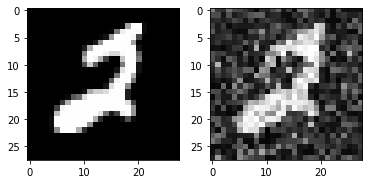

25  :  -1.516377480492838 25
50  :  -1.516377480492838 25
75  :  -1.4408340754896032 25
100  :  -1.3629229830335792 25
125  :  -1.0089302190004987 25
150  :  -1.0641096533761576 25
175  :  -0.9422824309050911 25
200  :  -0.719168499970936 25
225  :  -0.6997827672395922 25
250  :  -0.6997827672395922 25
275  :  -0.6319571977785137 25
300  :  -0.6362127581832995 25
325  :  -0.6312400751143497 25
350  :  -0.593330665252829 25
375  :  -0.568162913568339 25
400  :  -0.549159016384509 25
425  :  -0.5141608510245906 25
450  :  -0.5141608510245906 25
475  :  -0.5141608510245906 25
500  :  -0.47414742708310853 25
525  :  -0.47414742708310853 25
550  :  -0.47414742708310853 25
575  :  -0.47414742708310853 25
600  :  -0.46937270900442385 25
625  :  -0.4634433774003677 25
650  :  -0.4643743434708426 25
675  :  -0.4643743434708426 25
700  :  -0.4592561971692072 25
725  :  -0.4592561971692072 25
750  :  -0.44729593895326525 25
775  :  -0.4473061228151486 25
800  :  -0.4445155917635438 25
825  :  -0.

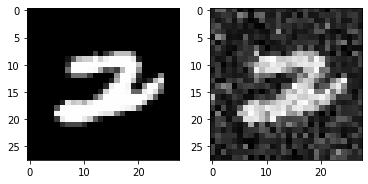

25  :  -0.7200939301809377 25
50  :  -0.7200939301809377 25
75  :  -0.7200939301809377 25
100  :  -0.7200939301809377 25
125  :  -0.6992959369116427 25
150  :  -0.6394103945449876 25
175  :  -0.6394103945449876 25
200  :  -0.6146481309500853 25
225  :  -0.5941688939809364 25
250  :  -0.5953504499881217 25
275  :  -0.5712322147624975 25
300  :  -0.5712322147624975 25
325  :  -0.545799850713941 25
350  :  -0.5374413459176233 25
375  :  -0.5376261610192616 25
400  :  -0.5371387256877922 25
425  :  -0.5085080094491328 25
450  :  -0.5085080094491328 25
475  :  -0.5085080094491328 25
500  :  -0.5085080094491328 25
525  :  -0.48247100324468317 25
550  :  -0.48247100324468317 25
575  :  -0.48247100324468317 25
600  :  -0.46872228153708007 25
625  :  -0.46872228153708007 25
650  :  -0.4575320653679321 25
675  :  -0.44914870204282864 25
700  :  -0.44226044550174937 25
725  :  -0.4338505087295791 25
750  :  -0.4316525341439852 25
775  :  -0.43030190977736893 25
800  :  -0.42943900735055807 25
825

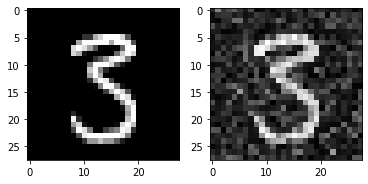

25  :  -0.7785484258334843 25
50  :  -0.7785484258334843 25
75  :  -0.7785484258334843 25
100  :  -0.7785484258334843 25
125  :  -0.7639939246427341 25
150  :  -0.7608481638261624 25
175  :  -0.7259992997409854 25
200  :  -0.7259992997409854 25
225  :  -0.7259992997409854 25
250  :  -0.7259992997409854 25
275  :  -0.7259992997409854 25
300  :  -0.7259992997409854 25
325  :  -0.6531890379126302 25
350  :  -0.6440336519645729 25
375  :  -0.6114010784283066 25
400  :  -0.6140925142778508 25
425  :  -0.575000501029727 25
450  :  -0.5756830905803465 25
475  :  -0.5756830905803465 25
500  :  -0.5628353927923253 25
525  :  -0.5371061545877853 25
550  :  -0.5368213391710925 25
575  :  -0.5368213391710925 25
600  :  -0.5268036695158769 25
625  :  -0.5166742691405202 25
650  :  -0.5033401405562198 25
675  :  -0.5033401405562198 25
700  :  -0.5033401405562198 25
725  :  -0.49707284637364113 25
750  :  -0.49030339823523483 25
775  :  -0.48195436358394295 25
800  :  -0.47278258128219763 25
825  :  

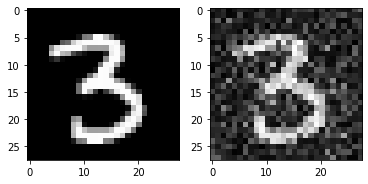

25  :  -0.7651905016441534 25
50  :  -0.7389802562214618 25
75  :  -0.6911635106458915 25
100  :  -0.6911635106458915 25
125  :  -0.6911635106458915 25
150  :  -0.6858719153772059 25
175  :  -0.6858719153772059 25
200  :  -0.6858719153772059 25
225  :  -0.6411078479856134 25
250  :  -0.6411078479856134 25
275  :  -0.6411078479856134 25
300  :  -0.6411078479856134 25
325  :  -0.6411078479856134 25
350  :  -0.6411078479856134 25
375  :  -0.6411078479856134 25
400  :  -0.607928542885803 25
425  :  -0.6061772920472017 25
450  :  -0.6061772920472017 25
475  :  -0.6061772920472017 25
500  :  -0.6061772920472017 25
525  :  -0.6061772920472017 25
550  :  -0.6061772920472017 25
575  :  -0.6061772920472017 25
600  :  -0.6061772920472017 25
625  :  -0.5582222261088212 25
650  :  -0.5581316426448917 25
675  :  -0.5581316426448917 25
700  :  -0.5581316426448917 25
725  :  -0.5581316426448917 25
750  :  -0.5581316426448917 25
775  :  -0.5581316426448917 25
800  :  -0.5453833382506195 25
825  :  -0.5

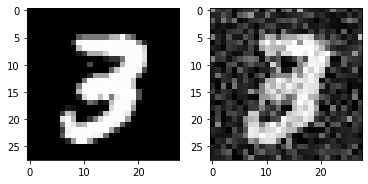

25  :  -0.7405829690278181 25
50  :  -0.7405829690278181 25
75  :  -0.7157896717591965 25
100  :  -0.7157896717591965 25
125  :  -0.7157896717591965 25
150  :  -0.7157896717591965 25
175  :  -0.7044637102290161 25
200  :  -0.6727480397554564 25
225  :  -0.6368828339928894 25
250  :  -0.6338948595693761 25
275  :  -0.622330123445878 25
300  :  -0.6005839970902354 25
325  :  -0.6005839970902354 25
350  :  -0.5368757774866744 25
375  :  -0.5170950094470033 25
400  :  -0.5106790574470894 25
425  :  -0.5017070806192365 25
450  :  -0.5015638036605714 25
475  :  -0.5015638036605714 25
500  :  -0.5015638036605714 25
525  :  -0.5015638036605714 25
550  :  -0.5010395743032672 25
575  :  -0.4956246767689638 25
600  :  -0.4916571310484693 25
625  :  -0.48647738956757547 25
650  :  -0.4812127917317156 25
675  :  -0.4804813380859215 25
700  :  -0.4804813380859215 25
725  :  -0.4804813380859215 25
750  :  -0.4748659161415565 25
775  :  -0.470377962011877 25
800  :  -0.470377962011877 25
825  :  -0.47

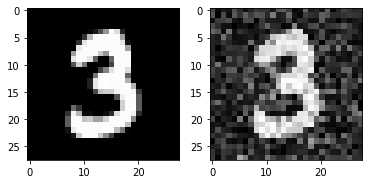

25  :  -0.70884688288041 25
50  :  -0.70884688288041 25
75  :  -0.7032955820641831 25
100  :  -0.6020862050240603 25
125  :  -0.6020862050240603 25
150  :  -0.6020862050240603 25
175  :  -0.6020862050240603 25
200  :  -0.6020862050240603 25
225  :  -0.6020862050240603 25
250  :  -0.6020862050240603 25
275  :  -0.5656248876337928 25
300  :  -0.5656248876337928 25
325  :  -0.5618945009792524 25
350  :  -0.5608602595315086 25
375  :  -0.5608602595315086 25
400  :  -0.5608602595315086 25
425  :  -0.5541540829676712 25
450  :  -0.5541540829676712 25
475  :  -0.5541540829676712 25
500  :  -0.5382573317034176 25
525  :  -0.5381481756752906 25
550  :  -0.5215587645299316 25
575  :  -0.5215587645299316 25
600  :  -0.5176495067406959 25
625  :  -0.5170446323831075 25
650  :  -0.507318056032892 25
675  :  -0.507318056032892 25
700  :  -0.507318056032892 25
725  :  -0.503485439208595 25
750  :  -0.4970541130563164 25
775  :  -0.4970523803190764 25
800  :  -0.4970523803190764 25
825  :  -0.49535647

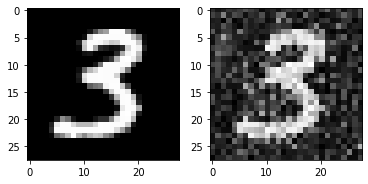

25  :  -0.8917630327155937 25
50  :  -0.8917630327155937 25
75  :  -0.8845226467142455 25
100  :  -0.8845226467142455 25
125  :  -0.8845226467142455 25
150  :  -0.8845226467142455 25
175  :  -0.8845226467142455 25
200  :  -0.851251516227149 25
225  :  -0.8495518966380311 25
250  :  -0.8495518966380311 25
275  :  -0.8495518966380311 25
300  :  -0.7404107842256515 25
325  :  -0.7306706771915501 25
350  :  -0.6895872092304252 25
375  :  -0.6895872092304252 25
400  :  -0.6895872092304252 25
425  :  -0.6805439245302136 25
450  :  -0.6805439245302136 25
475  :  -0.669505046296258 25
500  :  -0.669505046296258 25
525  :  -0.6632837380402978 25
550  :  -0.6632837380402978 25
575  :  -0.6621877596758656 25
600  :  -0.6615034266041973 25
625  :  -0.6615034266041973 25
650  :  -0.6604356138952765 25
675  :  -0.6574328736912378 25
700  :  -0.652493295388668 25
725  :  -0.6516202957375667 25
750  :  -0.6469805456204898 25
775  :  -0.6466971065011948 25
800  :  -0.6435304352855571 25
825  :  -0.6399

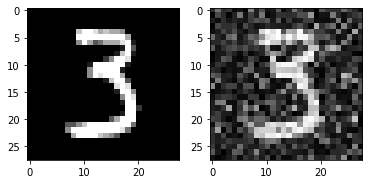

25  :  -1.3377165389552668 25
50  :  -1.1023299741204087 25
75  :  -1.263350535953999 25
100  :  -1.0100887999178239 25
125  :  -0.8343518091921687 25
150  :  -0.8343518091921687 25
175  :  -0.8343518091921687 25
200  :  -0.7899157579946281 25
225  :  -0.7604691123265888 25
250  :  -0.7457976228447936 25
275  :  -0.7438350164654328 25
300  :  -0.7438350164654328 25
325  :  -0.7422534741406455 25
350  :  -0.7372435576332017 25
375  :  -0.7372435576332017 25
400  :  -0.7372435576332017 25
425  :  -0.7372435576332017 25
450  :  -0.7372435576332017 25
475  :  -0.7316847654070568 25
500  :  -0.7321804328229427 25
525  :  -0.7321804328229427 25
550  :  -0.7321804328229427 25
575  :  -0.7321804328229427 25
600  :  -0.705566280756929 25
625  :  -0.705566280756929 25
650  :  -0.6954443311825307 25
675  :  -0.6946726754490189 25
700  :  -0.6946726754490189 25
725  :  -0.6797941570929409 25
750  :  -0.6810738670246215 25
775  :  -0.6722235198401532 25
800  :  -0.6453446231748443 25
825  :  -0.645

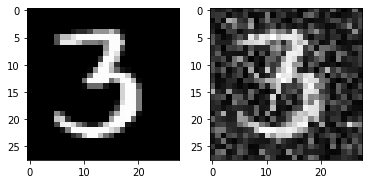

25  :  -1.3077214025305777 25
50  :  -1.2220919985531105 25
75  :  -0.9378765848375126 25
100  :  -0.877095744987455 25
125  :  -0.8551397420949562 25
150  :  -0.8551397420949562 25
175  :  -0.8551397420949562 25
200  :  -0.8551397420949562 25
225  :  -0.8488238210339338 25
250  :  -0.8488238210339338 25
275  :  -0.7946830511189309 25
300  :  -0.7946830511189309 25
325  :  -0.7946830511189309 25
350  :  -0.7816272174736967 25
375  :  -0.76588945782746 25
400  :  -0.7652036066927943 25
425  :  -0.7652036066927943 25
450  :  -0.7523265225142901 25
475  :  -0.7338911616982418 25
500  :  -0.732572906262186 25
525  :  -0.7187076802298844 25
550  :  -0.712201913193272 25
575  :  -0.712201913193272 25
600  :  -0.7000235001988719 25
625  :  -0.6937498830819333 25
650  :  -0.6937498830819333 25
675  :  -0.6908994995453928 25
700  :  -0.689297345007849 25
725  :  -0.6837572934767859 25
750  :  -0.6811047273228037 25
775  :  -0.6718262243036413 25
800  :  -0.6713697792687257 25
825  :  -0.6708623

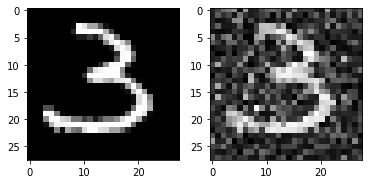

25  :  -0.8298932975642859 25
50  :  -0.8298932975642859 25
75  :  -0.8298932975642859 25
100  :  -0.8298932975642859 25
125  :  -0.8298932975642859 25
150  :  -0.8298932975642859 25
175  :  -0.8298932975642859 25
200  :  -0.8298932975642859 25
225  :  -0.8298932975642859 25
250  :  -0.8179691812629502 25
275  :  -0.8179691812629502 25
300  :  -0.7994673268869854 25
325  :  -0.7748806724272628 25
350  :  -0.7748806724272628 25
375  :  -0.7748806724272628 25
400  :  -0.7748806724272628 25
425  :  -0.7748806724272628 25
450  :  -0.7494274062188009 25
475  :  -0.7494274062188009 25
500  :  -0.7494274062188009 25
525  :  -0.7494274062188009 25
550  :  -0.7494274062188009 25
575  :  -0.730633937791235 25
600  :  -0.730633937791235 25
625  :  -0.730633937791235 25
650  :  -0.730633937791235 25
675  :  -0.7056233774246727 25
700  :  -0.7085262373476793 25
725  :  -0.7060788498965558 25
750  :  -0.7044492189763518 25
775  :  -0.6931183520457773 25
800  :  -0.683868789597214 25
825  :  -0.68386

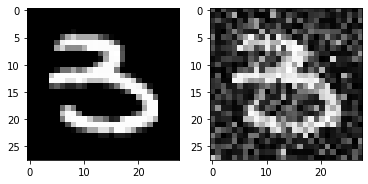

25  :  -0.7541568916681998 25
50  :  -0.7045449047592509 25
75  :  -0.6953925526401263 25
100  :  -0.6953925526401263 25
125  :  -0.6953925526401263 25
150  :  -0.6895428468380915 25
175  :  -0.680455929547962 25
200  :  -0.6778300344529609 25
225  :  -0.6663514402951356 25
250  :  -0.6538616055770934 25
275  :  -0.6538616055770934 25
300  :  -0.646918602442506 25
325  :  -0.6421157598899736 25
350  :  -0.5987716299244001 25
375  :  -0.6008435218706849 25
400  :  -0.6008435218706849 25
425  :  -0.5911160687021193 25
450  :  -0.5889197671211182 25
475  :  -0.5686660304749884 25
500  :  -0.563258109714847 25
525  :  -0.5472590271312272 25
550  :  -0.5462989595675947 25
575  :  -0.5462989595675947 25
600  :  -0.5342402387025129 25
625  :  -0.5343439967818824 25
650  :  -0.5305927386207419 25
675  :  -0.5199251754432166 25
700  :  -0.5045444321843179 25
725  :  -0.5045444321843179 25
750  :  -0.5045444321843179 25
775  :  -0.5045444321843179 25
800  :  -0.4929443535456164 25
825  :  -0.492

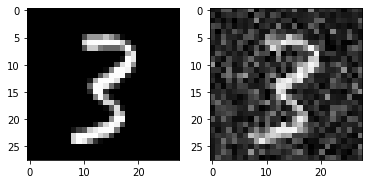

25  :  -0.9006844152289051 25
50  :  -0.9006844152289051 25
75  :  -0.8288475719076593 25
100  :  -0.8288475719076593 25
125  :  -0.811496010427178 25
150  :  -0.772470076493089 25
175  :  -0.7701340046164653 25
200  :  -0.7629144642366108 25
225  :  -0.7298716310942286 25
250  :  -0.7171051989962107 25
275  :  -0.715906335165434 25
300  :  -0.6857401614383603 25
325  :  -0.6857401614383603 25
350  :  -0.6857401614383603 25
375  :  -0.685692585564079 25
400  :  -0.6857401614383603 25
425  :  -0.6529050113204045 25
450  :  -0.6269738919136125 25
475  :  -0.6261377991304549 25
500  :  -0.6261377991304549 25
525  :  -0.6158177797624069 25
550  :  -0.6155367384859667 25
575  :  -0.6155367384859667 25
600  :  -0.6155367384859667 25
625  :  -0.6117615390884885 25
650  :  -0.5971881858159078 25
675  :  -0.5936656893362888 25
700  :  -0.5895019991751507 25
725  :  -0.5872058641616889 25
750  :  -0.5855335349228212 25
775  :  -0.5762410292725393 25
800  :  -0.5746535718508665 25
825  :  -0.5684

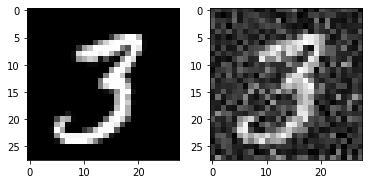

25  :  -0.8796365778325161 25
50  :  -0.8796365778325161 25
75  :  -0.8796365778325161 25
100  :  -0.8779248644734166 25
125  :  -0.8779248644734166 25
150  :  -0.8779248644734166 25
175  :  -0.8450954695860937 25
200  :  -0.8450954695860937 25
225  :  -0.8395075954596969 25
250  :  -0.8166507572818968 25
275  :  -0.8166507572818968 25
300  :  -0.8137286707074483 25
325  :  -0.8080824588209734 25
350  :  -0.7760528955069077 25
375  :  -0.7760528955069077 25
400  :  -0.7753841492776727 25
425  :  -0.7493747443809462 25
450  :  -0.7493747443809462 25
475  :  -0.7493747443809462 25
500  :  -0.7493747443809462 25
525  :  -0.7302391328867943 25
550  :  -0.7195061090226158 25
575  :  -0.7195061090226158 25
600  :  -0.7195061090226158 25
625  :  -0.7192364697857536 25
650  :  -0.718145419286766 25
675  :  -0.7172245989964734 25
700  :  -0.704725455390196 25
725  :  -0.6923543413440216 25
750  :  -0.6740205573518085 25
775  :  -0.6740205573518085 25
800  :  -0.6740205573518085 25
825  :  -0.67

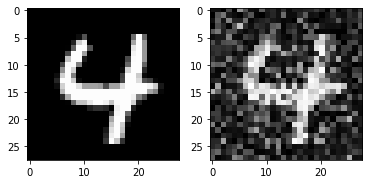

25  :  -1.2488922413301773 25
50  :  -1.02031555461217 25
75  :  -1.0492889312765856 25
100  :  -1.0440292709131016 25
125  :  -0.9174815577897077 25
150  :  -0.9174815577897077 25
175  :  -0.9174815577897077 25
200  :  -0.9174815577897077 25
225  :  -0.9169452852184425 25
250  :  -0.905733499446769 25
275  :  -0.905733499446769 25
300  :  -0.905733499446769 25
325  :  -0.905733499446769 25
350  :  -0.8801210652888511 25
375  :  -0.8801210652888511 25
400  :  -0.8801210652888511 25
425  :  -0.8621052203366424 25
450  :  -0.8247032181819465 25
475  :  -0.7970420711029498 25
500  :  -0.7715356751220135 25
525  :  -0.7417081252159967 25
550  :  -0.7417081252159967 25
575  :  -0.7417081252159967 25
600  :  -0.7417081252159967 25
625  :  -0.7225760755539121 25
650  :  -0.7225737042849556 25
675  :  -0.7225737042849556 25
700  :  -0.7225737042849556 25
725  :  -0.7146486869837634 25
750  :  -0.7060477752308061 25
775  :  -0.6935775119751733 25
800  :  -0.6916745995028073 25
825  :  -0.675694

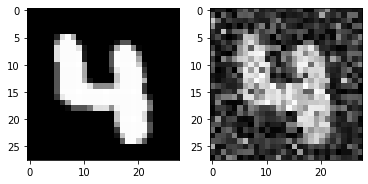

25  :  -1.3018260524483147 25
50  :  -1.3018260524483147 25
75  :  -1.2139953754366481 25
100  :  -1.1224063088540108 25
125  :  -1.0846350969241714 25
150  :  -1.0446711486322178 25
175  :  -1.0446711486322178 25
200  :  -1.0279840384324501 25
225  :  -0.9905993000447133 25
250  :  -0.868820487884933 25
275  :  -0.8463177998536129 25
300  :  -0.8469854199081921 25
325  :  -0.8469854199081921 25
350  :  -0.8469854199081921 25
375  :  -0.8469854199081921 25
400  :  -0.8469854199081921 25
425  :  -0.8469854199081921 25
450  :  -0.8469854199081921 25
475  :  -0.8469854199081921 25
500  :  -0.8469854199081921 25
525  :  -0.8469854199081921 25
550  :  -0.8281934785099676 25
575  :  -0.8245450541700508 25
600  :  -0.8182641014425176 25
625  :  -0.8096912942283427 25
650  :  -0.8037429984144551 25
675  :  -0.8017718957783717 25
700  :  -0.7995929612218302 25
725  :  -0.798458058836589 25
750  :  -0.7941367766523171 25
775  :  -0.7941367766523171 25
800  :  -0.7919771941698308 25
825  :  -0.78

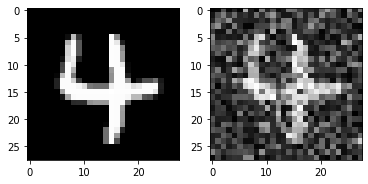

25  :  -0.8817127567951972 25
50  :  -0.8817127567951972 25
75  :  -0.8817127567951972 25
100  :  -0.8817127567951972 25
125  :  -0.8817127567951972 25
150  :  -0.8747600252576393 25
175  :  -0.8275543390898223 25
200  :  -0.8275543390898223 25
225  :  -0.806979194917113 25
250  :  -0.7927798648464781 25
275  :  -0.7927798648464781 25
300  :  -0.7426196702651959 25
325  :  -0.7300218314670996 25
350  :  -0.688916672006755 25
375  :  -0.6658049902631782 25
400  :  -0.6658049902631782 25
425  :  -0.6658049902631782 25
450  :  -0.6637444782978599 25
475  :  -0.6630527922024216 25
500  :  -0.6498421575831901 25
525  :  -0.6498421575831901 25
550  :  -0.6336366498341306 25
575  :  -0.633389255047971 25
600  :  -0.6290267976051185 25
625  :  -0.6290267976051185 25
650  :  -0.6133924965822053 25
675  :  -0.6066548866634669 25
700  :  -0.5990639461904255 25
725  :  -0.5931712040291988 25
750  :  -0.5786196682275278 25
775  :  -0.5786196682275278 25
800  :  -0.5786196682275278 25
825  :  -0.578

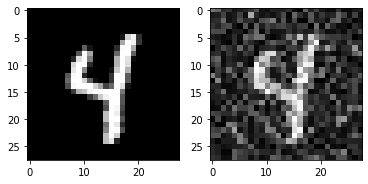

25  :  -0.8011330647947947 25
50  :  -0.8011330647947947 25
75  :  -0.8011330647947947 25
100  :  -0.8011330647947947 25
125  :  -0.8009726362023664 25
150  :  -0.6599828938995485 25
175  :  -0.6601447035028267 25
200  :  -0.6601447035028267 25
225  :  -0.6601447035028267 25
250  :  -0.652584787507001 25
275  :  -0.6389001778743211 25
300  :  -0.6141304686970561 25
325  :  -0.6086425774605317 25
350  :  -0.6086425774605317 25
375  :  -0.6009554196455162 25
400  :  -0.5744662500246693 25
425  :  -0.5714055645916112 25
450  :  -0.5743394577426051 25
475  :  -0.5652473688824038 25
500  :  -0.5598127515105558 25
525  :  -0.5403789376998507 25
550  :  -0.5296334140099515 25
575  :  -0.5296334140099515 25
600  :  -0.5260593560972842 25
625  :  -0.5260593560972842 25
650  :  -0.5260593560972842 25
675  :  -0.5253136570597248 25
700  :  -0.5209990942128406 25
725  :  -0.5198410075707909 25
750  :  -0.5193513655437834 25
775  :  -0.5183193467568235 25
800  :  -0.5183193467568235 25
825  :  -0.5

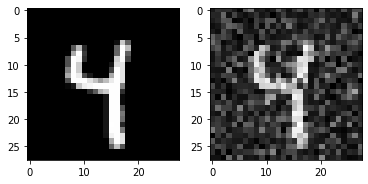

25  :  -0.7380817966871478 25
50  :  -0.7380817966871478 25
75  :  -0.7013142993944497 25
100  :  -0.6663866224785966 25
125  :  -0.6421061044430223 25
150  :  -0.6170737460789095 25
175  :  -0.6108630306789211 25
200  :  -0.5484572111206643 25
225  :  -0.5498332367553418 25
250  :  -0.5498332367553418 25
275  :  -0.5223469060473532 25
300  :  -0.498867894697939 25
325  :  -0.49953424903105614 25
350  :  -0.49672921253557656 25
375  :  -0.498484019200788 25
400  :  -0.49832431591086024 25
425  :  -0.4924842316698058 25
450  :  -0.48147566956729915 25
475  :  -0.4744747464596015 25
500  :  -0.4668163277315863 25
525  :  -0.4670210760506397 25
550  :  -0.4543203910537792 25
575  :  -0.44883396901126404 25
600  :  -0.44035652849474227 25
625  :  -0.42488935425670027 25
650  :  -0.42453564845088054 25
675  :  -0.41316111158496804 25
700  :  -0.41316111158496804 25
725  :  -0.4037591790395354 25
750  :  -0.4037591790395354 25
775  :  -0.4037591790395354 25
800  :  -0.3943129779630533 25
825

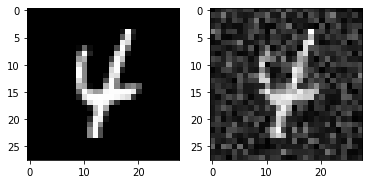

25  :  -0.7690603932689073 25
50  :  -0.7465332213883189 25
75  :  -0.7187340447831267 25
100  :  -0.7187340447831267 25
125  :  -0.7040647593016969 25
150  :  -0.6726861486779279 25
175  :  -0.6532216450980934 25
200  :  -0.6458920817608147 25
225  :  -0.6224732495817125 25
250  :  -0.5921893734925676 25
275  :  -0.5525997790171835 25
300  :  -0.5486406936262467 25
325  :  -0.5486406936262467 25
350  :  -0.5418941393668357 25
375  :  -0.5258416078262722 25
400  :  -0.5190981904041719 25
425  :  -0.5183025422815093 25
450  :  -0.5183025422815093 25
475  :  -0.5127687008999438 25
500  :  -0.5018398602964353 25
525  :  -0.48454828596529753 25
550  :  -0.48454828596529753 25
575  :  -0.48454828596529753 25
600  :  -0.4794921372241394 25
625  :  -0.4787598537787513 25
650  :  -0.4784017411664684 25
675  :  -0.4721942383931599 25
700  :  -0.4668655637368373 25
725  :  -0.4604430221179996 25
750  :  -0.4604430221179996 25
775  :  -0.4604430221179996 25
800  :  -0.45985413135885134 25
825  : 

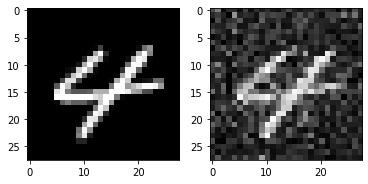

25  :  -0.7646183434709668 25
50  :  -0.7646183434709668 25
75  :  -0.7646183434709668 25
100  :  -0.7646183434709668 25
125  :  -0.7646183434709668 25
150  :  -0.7556424982094894 25
175  :  -0.7491801165164278 25
200  :  -0.6844513456785044 25
225  :  -0.6720432796641751 25
250  :  -0.6720432796641751 25
275  :  -0.6720432796641751 25
300  :  -0.6720432796641751 25
325  :  -0.6720432796641751 25
350  :  -0.6720432796641751 25
375  :  -0.6589482712844561 25
400  :  -0.6534685581432678 25
425  :  -0.6118728347330231 25
450  :  -0.6098439629217947 25
475  :  -0.5987893013225178 25
500  :  -0.5984382035219897 25
525  :  -0.5984382035219897 25
550  :  -0.5911009262005253 25
575  :  -0.5785493798813661 25
600  :  -0.5566686023859695 25
625  :  -0.5432891212203754 25
650  :  -0.5432891212203754 25
675  :  -0.5432891212203754 25
700  :  -0.5432891212203754 25
725  :  -0.5432891212203754 25
750  :  -0.5432891212203754 25
775  :  -0.5294505840645141 25
800  :  -0.5294483312484455 25
825  :  -0.

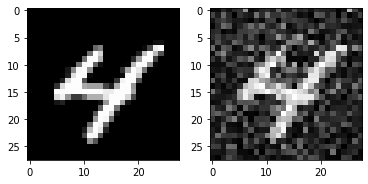

25  :  -0.6969058035798967 25
50  :  -0.6969058035798967 25
75  :  -0.6969058035798967 25
100  :  -0.6969058035798967 25
125  :  -0.6322510549163152 25
150  :  -0.6313331612305084 25
175  :  -0.6313331612305084 25
200  :  -0.623907198524464 25
225  :  -0.570051815840019 25
250  :  -0.5618731600354865 25
275  :  -0.5618731600354865 25
300  :  -0.5585695548966303 25
325  :  -0.54489058850327 25
350  :  -0.5020866670000116 25
375  :  -0.5020866670000116 25
400  :  -0.474677702387872 25
425  :  -0.474677702387872 25
450  :  -0.474677702387872 25
475  :  -0.472526800014877 25
500  :  -0.46362627861695827 25
525  :  -0.46362627861695827 25
550  :  -0.4631063773349259 25
575  :  -0.46056115786766905 25
600  :  -0.4518492673312211 25
625  :  -0.45118167295632783 25
650  :  -0.4443001614834272 25
675  :  -0.44092645831122146 25
700  :  -0.44102235077965246 25
725  :  -0.4400619533488944 25
750  :  -0.4400619533488944 25
775  :  -0.4350140747533666 25
800  :  -0.43161808550604275 25
825  :  -0.4

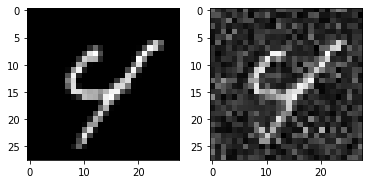

25  :  -1.390868230340921 25
50  :  -1.0137215309284404 25
75  :  -0.8697569961838592 25
100  :  -0.8391091386428617 25
125  :  -0.8327487051978721 25
150  :  -0.8319439887240623 25
175  :  -0.8177971123157683 25
200  :  -0.7191098348662448 25
225  :  -0.7191098348662448 25
250  :  -0.7191098348662448 25
275  :  -0.7191098348662448 25
300  :  -0.7191098348662448 25
325  :  -0.7191098348662448 25
350  :  -0.7191098348662448 25
375  :  -0.7191098348662448 25
400  :  -0.6949585530591962 25
425  :  -0.6925775429244485 25
450  :  -0.6925775429244485 25
475  :  -0.6775434844137767 25
500  :  -0.6775434844137767 25
525  :  -0.6561944887030216 25
550  :  -0.6466233358590807 25
575  :  -0.6466233358590807 25
600  :  -0.6466233358590807 25
625  :  -0.6322498709388802 25
650  :  -0.6322498709388802 25
675  :  -0.6231619447213572 25
700  :  -0.6231619447213572 25
725  :  -0.6231619447213572 25
750  :  -0.6217508218858856 25
775  :  -0.610892995537019 25
800  :  -0.6054083176945801 25
825  :  -0.60

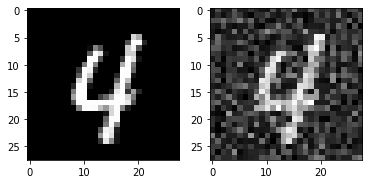

25  :  -0.6931508759932903 25
50  :  -0.6931508759932903 25
75  :  -0.694688499316628 25
100  :  -0.694688499316628 25
125  :  -0.694688499316628 25
150  :  -0.694688499316628 25
175  :  -0.6627582306233843 25
200  :  -0.6602843274733419 25
225  :  -0.5934703669397645 25
250  :  -0.5934703669397645 25
275  :  -0.5934703669397645 25
300  :  -0.5934703669397645 25
325  :  -0.5921397474238443 25
350  :  -0.5921397474238443 25
375  :  -0.5921397474238443 25
400  :  -0.5921397474238443 25
425  :  -0.5921397474238443 25
450  :  -0.5921397474238443 25
475  :  -0.5921397474238443 25
500  :  -0.5921397474238443 25
525  :  -0.5921397474238443 25
550  :  -0.5921397474238443 25
575  :  -0.5921397474238443 25
600  :  -0.5921397474238443 25
625  :  -0.5921397474238443 25
650  :  -0.5921397474238443 25
675  :  -0.5921397474238443 25
700  :  -0.5921397474238443 25
725  :  -0.5921397474238443 25
750  :  -0.5921397474238443 25
775  :  -0.5921397474238443 25
800  :  -0.5921397474238443 25
825  :  -0.5921

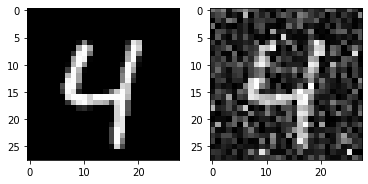

25  :  -0.7765516932676615 25
50  :  -0.7526784279959067 25
75  :  -0.7526784279959067 25
100  :  -0.7517422058386087 25
125  :  -0.7526784279959067 25
150  :  -0.722560547081214 25
175  :  -0.6634970012470478 25
200  :  -0.6634970012470478 25
225  :  -0.6634970012470478 25
250  :  -0.6634970012470478 25
275  :  -0.6634970012470478 25
300  :  -0.6634970012470478 25
325  :  -0.6634970012470478 25
350  :  -0.6634970012470478 25
375  :  -0.6606102282255757 25
400  :  -0.6571994632726266 25
425  :  -0.6213890794371848 25
450  :  -0.6223922240199931 25
475  :  -0.6223922240199931 25
500  :  -0.6223922240199931 25
525  :  -0.6223922240199931 25
550  :  -0.6073585550305742 25
575  :  -0.6093723853516948 25
600  :  -0.6067642409197938 25
625  :  -0.6050788570473902 25
650  :  -0.5971276278565689 25
675  :  -0.5971276278565689 25
700  :  -0.595246551371462 25
725  :  -0.5881602209997667 25
750  :  -0.5801143488940188 25
775  :  -0.5801355674545301 25
800  :  -0.5801355674545301 25
825  :  -0.58

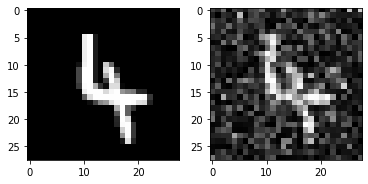

25  :  -0.7708547618174011 25
50  :  -0.7708547618174011 25
75  :  -0.7516880805702155 25
100  :  -0.7549677700885626 25
125  :  -0.6980611807211776 25
150  :  -0.6980611807211776 25
175  :  -0.6892003539851546 25
200  :  -0.686117282186804 25
225  :  -0.686117282186804 25
250  :  -0.6314017729696597 25
275  :  -0.6265286496728109 25
300  :  -0.6131588190366928 25
325  :  -0.60101373813094 25
350  :  -0.60101373813094 25
375  :  -0.60101373813094 25
400  :  -0.60101373813094 25
425  :  -0.5758404883386128 25
450  :  -0.5780163903550206 25
475  :  -0.5780163903550206 25
500  :  -0.5770915901462152 25
525  :  -0.5633689502225661 25
550  :  -0.5499181158390325 25
575  :  -0.5499181158390325 25
600  :  -0.5498922353533129 25
625  :  -0.5499181158390325 25
650  :  -0.5450563575314578 25
675  :  -0.5441194529896844 25
700  :  -0.5317080088861978 25
725  :  -0.5315875140362012 25
750  :  -0.5280138068913358 25
775  :  -0.5172382847233463 25
800  :  -0.516606661249791 25
825  :  -0.51650258524

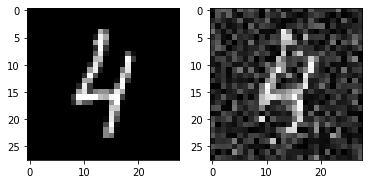

25  :  -0.6972801507274802 25
50  :  -0.6972801507274802 25
75  :  -0.6065916860920737 25
100  :  -0.6065916860920737 25
125  :  -0.5628126829699045 25
150  :  -0.5699049753612313 25
175  :  -0.5699049753612313 25
200  :  -0.563398925941835 25
225  :  -0.5670977741277439 25
250  :  -0.5670977741277439 25
275  :  -0.5557935374812322 25
300  :  -0.5548715037973355 25
325  :  -0.5526730396553177 25
350  :  -0.5519369739306106 25
375  :  -0.5519369739306106 25
400  :  -0.5166275048090956 25
425  :  -0.5121093679619853 25
450  :  -0.5120776234008999 25
475  :  -0.5120776234008999 25
500  :  -0.5120776234008999 25
525  :  -0.5120776234008999 25
550  :  -0.5120776234008999 25
575  :  -0.5120776234008999 25
600  :  -0.5120776234008999 25
625  :  -0.5120776234008999 25
650  :  -0.4974322949441199 25
675  :  -0.4974322949441199 25
700  :  -0.4974322949441199 25
725  :  -0.4974322949441199 25
750  :  -0.4974322949441199 25
775  :  -0.4727903953675019 25
800  :  -0.4727903953675019 25
825  :  -0.4

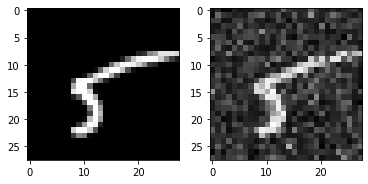

25  :  -1.053329759642282 25
50  :  -1.053329759642282 25
75  :  -0.9702842877353375 25
100  :  -0.9702842877353375 25
125  :  -0.9702842877353375 25
150  :  -0.9159894562625388 25
175  :  -0.9040514729338893 25
200  :  -0.9040514729338893 25
225  :  -0.9040514729338893 25
250  :  -0.9040514729338893 25
275  :  -0.8989942598972902 25
300  :  -0.8684507819177241 25
325  :  -0.8665107311577118 25
350  :  -0.8494155624328492 25
375  :  -0.8494155624328492 25
400  :  -0.8451478951461759 25
425  :  -0.8142582874879174 25
450  :  -0.8124365352434169 25
475  :  -0.8124365352434169 25
500  :  -0.8001699106786417 25
525  :  -0.7846544482193913 25
550  :  -0.7750476997504636 25
575  :  -0.7748523576019801 25
600  :  -0.7639580313829155 25
625  :  -0.7527373895259111 25
650  :  -0.7527373895259111 25
675  :  -0.7364410350146657 25
700  :  -0.7328875523667249 25
725  :  -0.7328875523667249 25
750  :  -0.7328875523667249 25
775  :  -0.717822476864584 25
800  :  -0.7178117578771848 25
825  :  -0.717

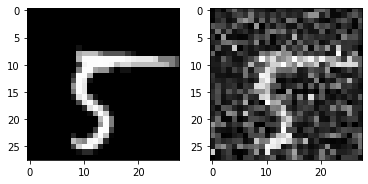

25  :  -0.7085237253109675 25
50  :  -0.6739328953631742 25
75  :  -0.6580727762414775 25
100  :  -0.6511931447571258 25
125  :  -0.6327237449824983 25
150  :  -0.5978354296793107 25
175  :  -0.5978354296793107 25
200  :  -0.5941102573662267 25
225  :  -0.5732175594600006 25
250  :  -0.5643327103871265 25
275  :  -0.535317826344921 25
300  :  -0.5354220008219295 25
325  :  -0.5266495936269366 25
350  :  -0.5259205581831758 25
375  :  -0.48650446725839247 25
400  :  -0.5036120234178527 25
425  :  -0.4552161980226578 25
450  :  -0.4588739868852646 25
475  :  -0.4588739868852646 25
500  :  -0.44056693712705775 25
525  :  -0.44056693712705775 25
550  :  -0.4325129486138165 25
575  :  -0.42579098228482715 25
600  :  -0.40592875393949124 25
625  :  -0.4069034912134848 25
650  :  -0.3962319708585591 25
675  :  -0.3962151206496387 25
700  :  -0.390797295280672 25
725  :  -0.3877292438024228 25
750  :  -0.38221895412624707 25
775  :  -0.3799343030907697 25
800  :  -0.3799343030907697 25
825  : 

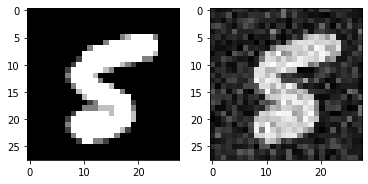

25  :  -0.8554230001248158 25
50  :  -0.8554230001248158 25
75  :  -0.8554230001248158 25
100  :  -0.8333186492141682 25
125  :  -0.798336630914066 25
150  :  -0.798336630914066 25
175  :  -0.798336630914066 25
200  :  -0.798336630914066 25
225  :  -0.798336630914066 25
250  :  -0.7832037723917185 25
275  :  -0.7476297614904883 25
300  :  -0.7476297614904883 25
325  :  -0.7334107463638662 25
350  :  -0.7318868007098593 25
375  :  -0.7318868007098593 25
400  :  -0.7002714737335896 25
425  :  -0.6867241864989702 25
450  :  -0.6804475573295601 25
475  :  -0.6526339420699763 25
500  :  -0.6526339420699763 25
525  :  -0.6519716123290931 25
550  :  -0.6516681973289384 25
575  :  -0.6516681973289384 25
600  :  -0.6280720744862238 25
625  :  -0.6253472894185665 25
650  :  -0.6180246713574138 25
675  :  -0.6134091006088551 25
700  :  -0.6072841789122072 25
725  :  -0.607452076512303 25
750  :  -0.5955919318337708 25
775  :  -0.5955919318337708 25
800  :  -0.5875050548250822 25
825  :  -0.579440

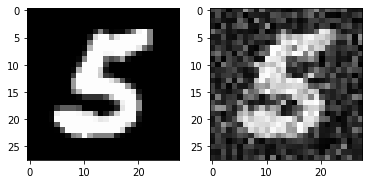

25  :  -0.8453793418383044 25
50  :  -0.8453793418383044 25
75  :  -0.7975123331963012 25
100  :  -0.7975123331963012 25
125  :  -0.7739902058835766 25
150  :  -0.7255568899716569 25
175  :  -0.7103692936619175 25
200  :  -0.7103692936619175 25
225  :  -0.7103692936619175 25
250  :  -0.7103692936619175 25
275  :  -0.7103692936619175 25
300  :  -0.6583115623628462 25
325  :  -0.6546526512024211 25
350  :  -0.6443387517399164 25
375  :  -0.6323309072900696 25
400  :  -0.6323309072900696 25
425  :  -0.6137461981597134 25
450  :  -0.6137087340935017 25
475  :  -0.6121027939842862 25
500  :  -0.6068124743040599 25
525  :  -0.5800942859895906 25
550  :  -0.5800942859895906 25
575  :  -0.5800942859895906 25
600  :  -0.5662878221013905 25
625  :  -0.5662878221013905 25
650  :  -0.5528634305949813 25
675  :  -0.5528634305949813 25
700  :  -0.5528634305949813 25
725  :  -0.5528634305949813 25
750  :  -0.5459337063529293 25
775  :  -0.5459337063529293 25
800  :  -0.5432538223224406 25
825  :  -0.

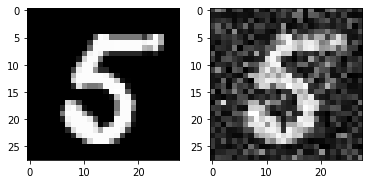

25  :  -0.6783649765135558 25
50  :  -0.6783649765135558 25
75  :  -0.671855663441856 25
100  :  -0.601659870838636 25
125  :  -0.5927174166309581 25
150  :  -0.5717295951108403 25
175  :  -0.5732847757434683 25
200  :  -0.5498864665145321 25
225  :  -0.5498864665145321 25
250  :  -0.5278058090596509 25
275  :  -0.5378052903803943 25
300  :  -0.5378052903803943 25
325  :  -0.5378052903803943 25
350  :  -0.5378052903803943 25
375  :  -0.5181269925921637 25
400  :  -0.5181269925921637 25
425  :  -0.5181269925921637 25
450  :  -0.5181269925921637 25
475  :  -0.4939621818250586 25
500  :  -0.4939621818250586 25
525  :  -0.4813185812750935 25
550  :  -0.4668250498913271 25
575  :  -0.4668250498913271 25
600  :  -0.4668250498913271 25
625  :  -0.4668250498913271 25
650  :  -0.4668250498913271 25
675  :  -0.4567791167656182 25
700  :  -0.44880409351646 25
725  :  -0.44880582506013644 25
750  :  -0.44880582506013644 25
775  :  -0.44338567153885 25
800  :  -0.43862690027206563 25
825  :  -0.434

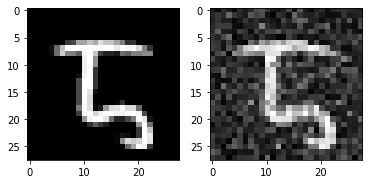

25  :  -0.6208468317931926 25
50  :  -0.6208468317931926 25
75  :  -0.6208468317931926 25
100  :  -0.6208468317931926 25
125  :  -0.5852645312344249 25
150  :  -0.576182041837539 25
175  :  -0.5288053457082049 25
200  :  -0.5288053457082049 25
225  :  -0.4829289754162769 25
250  :  -0.4829289754162769 25
275  :  -0.4829289754162769 25
300  :  -0.4829289754162769 25
325  :  -0.4255139753672339 25
350  :  -0.4255139753672339 25
375  :  -0.4255139753672339 25
400  :  -0.4221497101570695 25
425  :  -0.4218796335785219 25
450  :  -0.4218796335785219 25
475  :  -0.4150668014656148 25
500  :  -0.40924615560802813 25
525  :  -0.4037560480365865 25
550  :  -0.40113378655119203 25
575  :  -0.3954505930959641 25
600  :  -0.3884212093509093 25
625  :  -0.37072493745194 25
650  :  -0.37072493745194 25
675  :  -0.37072493745194 25
700  :  -0.3591327539318223 25
725  :  -0.3591327539318223 25
750  :  -0.3591327539318223 25
775  :  -0.3591327539318223 25
800  :  -0.3591327539318223 25
825  :  -0.35913

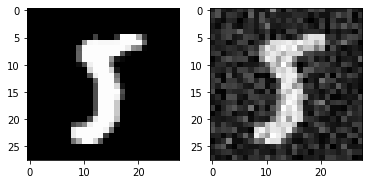

25  :  -0.6988091595793711 25
50  :  -0.6988091595793711 25
75  :  -0.6988091595793711 25
100  :  -0.6988091595793711 25
125  :  -0.6207149410349602 25
150  :  -0.6207149410349602 25
175  :  -0.6064765000609622 25
200  :  -0.571068751222719 25
225  :  -0.5513580752765355 25
250  :  -0.5243973570208511 25
275  :  -0.5243973570208511 25
300  :  -0.517750405437558 25
325  :  -0.516240483542624 25
350  :  -0.47471677332555806 25
375  :  -0.4745803602999038 25
400  :  -0.4745803602999038 25
425  :  -0.46514116309153963 25
450  :  -0.4439574603586359 25
475  :  -0.43169948989939166 25
500  :  -0.43169948989939166 25
525  :  -0.40699196486693423 25
550  :  -0.40714516347496654 25
575  :  -0.40714516347496654 25
600  :  -0.40714516347496654 25
625  :  -0.40693511334190047 25
650  :  -0.40693511334190047 25
675  :  -0.4004414799247328 25
700  :  -0.3906227583416203 25
725  :  -0.390774007950627 25
750  :  -0.38814153289057274 25
775  :  -0.3823261068449785 25
800  :  -0.3762653283445576 25
825 

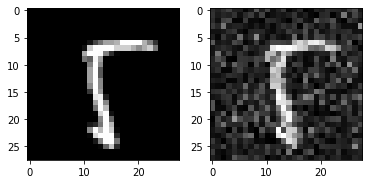

25  :  -0.8650310559131309 25
50  :  -0.8484381116639428 25
75  :  -0.8157126023171988 25
100  :  -0.862904181370802 25
125  :  -0.8620109219157572 25
150  :  -0.8589537836286116 25
175  :  -0.8338144524893674 25
200  :  -0.8338144524893674 25
225  :  -0.8316926457993847 25
250  :  -0.8153455054566991 25
275  :  -0.7915597496799471 25
300  :  -0.79060383900423 25
325  :  -0.75705381280104 25
350  :  -0.75705381280104 25
375  :  -0.7567016435659593 25
400  :  -0.7370735120056706 25
425  :  -0.7370735120056706 25
450  :  -0.7347008805483077 25
475  :  -0.7088117890184078 25
500  :  -0.6867107846717146 25
525  :  -0.6867107846717146 25
550  :  -0.6573230983094198 25
575  :  -0.6573438318212279 25
600  :  -0.6573438318212279 25
625  :  -0.6573438318212279 25
650  :  -0.6573438318212279 25
675  :  -0.6530180843643294 25
700  :  -0.6487037506833031 25
725  :  -0.6403337059019902 25
750  :  -0.6403337059019902 25
775  :  -0.6333408813011017 25
800  :  -0.6299268447504993 25
825  :  -0.6287498

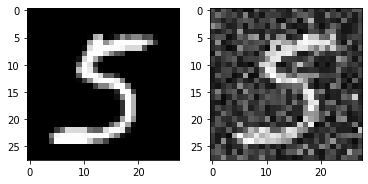

25  :  -0.6825030613718344 25
50  :  -0.6497681600766887 25
75  :  -0.6438264332607724 25
100  :  -0.6438264332607724 25
125  :  -0.6438264332607724 25
150  :  -0.6438264332607724 25
175  :  -0.6276046639297217 25
200  :  -0.6212824984751548 25
225  :  -0.6103158470278618 25
250  :  -0.5877802143960951 25
275  :  -0.5706166385529285 25
300  :  -0.5706166385529285 25
325  :  -0.5416371714644361 25
350  :  -0.5387601076314317 25
375  :  -0.49895305039905824 25
400  :  -0.4931969085921498 25
425  :  -0.47349009642979845 25
450  :  -0.4523196124488379 25
475  :  -0.4523196124488379 25
500  :  -0.44529263104937433 25
525  :  -0.44529263104937433 25
550  :  -0.44529263104937433 25
575  :  -0.4410207025028904 25
600  :  -0.4397486590986699 25
625  :  -0.4317144934559344 25
650  :  -0.4317144934559344 25
675  :  -0.4306164299861024 25
700  :  -0.42908205659309717 25
725  :  -0.4226074144487282 25
750  :  -0.42061902803109597 25
775  :  -0.4175283550773522 25
800  :  -0.41397994372358093 25
825

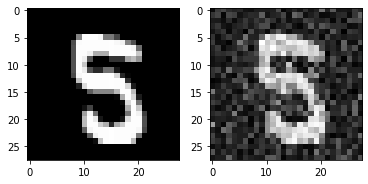

25  :  -0.7566821424984882 25
50  :  -0.6771231543178533 25
75  :  -0.6771231543178533 25
100  :  -0.6771231543178533 25
125  :  -0.6771231543178533 25
150  :  -0.6729191443913249 25
175  :  -0.6717401340833473 25
200  :  -0.6697549059775549 25
225  :  -0.6696276706525015 25
250  :  -0.6626552939797212 25
275  :  -0.6591166550648755 25
300  :  -0.6551404318424656 25
325  :  -0.6365458251234071 25
350  :  -0.6261257437618932 25
375  :  -0.6085316820833424 25
400  :  -0.5866203690480449 25
425  :  -0.5701084302133479 25
450  :  -0.5702465385886093 25
475  :  -0.5676466969467275 25
500  :  -0.5511553226279065 25
525  :  -0.5501361299275653 25
550  :  -0.5450096455566675 25
575  :  -0.5366019468880214 25
600  :  -0.5374368244831065 25
625  :  -0.5154823936327476 25
650  :  -0.5154823936327476 25
675  :  -0.5154823936327476 25
700  :  -0.5121121012445083 25
725  :  -0.5121121012445083 25
750  :  -0.4988459532148116 25
775  :  -0.48226417139131017 25
800  :  -0.4827397464954656 25
825  :  -0

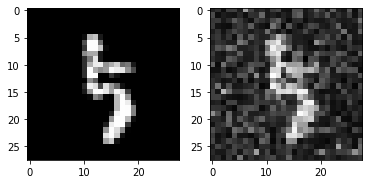

25  :  -0.7556355048998693 25
50  :  -0.7556355048998693 25
75  :  -0.710459841770881 25
100  :  -0.5518418645111602 25
125  :  -0.5518418645111602 25
150  :  -0.5518418645111602 25
175  :  -0.5518418645111602 25
200  :  -0.5518418645111602 25
225  :  -0.5518418645111602 25
250  :  -0.5518418645111602 25
275  :  -0.5518418645111602 25
300  :  -0.5479592767473829 25
325  :  -0.5335575870296692 25
350  :  -0.5273066237073198 25
375  :  -0.5253059552248542 25
400  :  -0.5164069463315668 25
425  :  -0.49766347356819995 25
450  :  -0.497782999553004 25
475  :  -0.497782999553004 25
500  :  -0.4906703743829215 25
525  :  -0.4907109021092836 25
550  :  -0.4907109021092836 25
575  :  -0.48154908851292255 25
600  :  -0.47388885480353227 25
625  :  -0.4630002795376258 25
650  :  -0.45980027408245794 25
675  :  -0.4524159650744396 25
700  :  -0.4524159650744396 25
725  :  -0.4513790383103674 25
750  :  -0.45146301307672554 25
775  :  -0.45146301307672554 25
800  :  -0.44963682889431267 25
825  : 

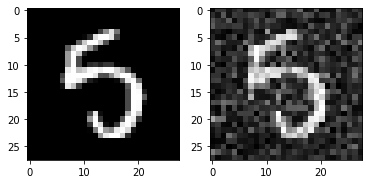

25  :  -0.7619959529367957 25
50  :  -0.7619959529367957 25
75  :  -0.665960758452985 25
100  :  -0.6434237138421721 25
125  :  -0.5328617650459468 25
150  :  -0.5328617650459468 25
175  :  -0.5328617650459468 25
200  :  -0.5328617650459468 25
225  :  -0.5285022490405279 25
250  :  -0.5285022490405279 25
275  :  -0.4606061853106498 25
300  :  -0.44133781884600776 25
325  :  -0.4028405109526343 25
350  :  -0.4028405109526343 25
375  :  -0.39448834354105167 25
400  :  -0.39448834354105167 25
425  :  -0.37669319794740697 25
450  :  -0.3705986068953153 25
475  :  -0.3669413894257607 25
500  :  -0.3666819566454871 25
525  :  -0.36602008821735443 25
550  :  -0.3639571200096806 25
575  :  -0.3589489735812209 25
600  :  -0.355808034126434 25
625  :  -0.3468351673712353 25
650  :  -0.34479436292673227 25
675  :  -0.3442329120325214 25
700  :  -0.33947813590036313 25
725  :  -0.33618103209632577 25
750  :  -0.33618103209632577 25
775  :  -0.3334404512599416 25
800  :  -0.3318203297534532 25
825 

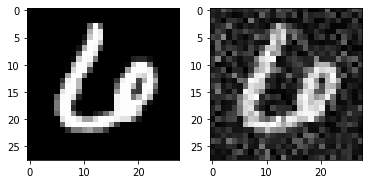

25  :  -1.2754829788249926 25
50  :  -1.2347646034824813 25
75  :  -1.233338770421624 25
100  :  -1.041605250284836 25
125  :  -0.9676974104397518 25
150  :  -0.912134854327566 25
175  :  -0.9221277927951645 25
200  :  -0.8958463974560316 25
225  :  -0.8804880105377062 25
250  :  -0.8804880105377062 25
275  :  -0.8653002151602966 25
300  :  -0.8653002151602966 25
325  :  -0.8653002151602966 25
350  :  -0.8027264852382243 25
375  :  -0.8027264852382243 25
400  :  -0.8027264852382243 25
425  :  -0.8027264852382243 25
450  :  -0.8027264852382243 25
475  :  -0.7876189423163185 25
500  :  -0.7602503786946686 25
525  :  -0.756306227864801 25
550  :  -0.756306227864801 25
575  :  -0.7431305211053114 25
600  :  -0.7431305211053114 25
625  :  -0.723625905942415 25
650  :  -0.7236380398149012 25
675  :  -0.7236380398149012 25
700  :  -0.7153365075192639 25
725  :  -0.7125841784340667 25
750  :  -0.7068367828713074 25
775  :  -0.7027918757782492 25
800  :  -0.6999726189267224 25
825  :  -0.700132

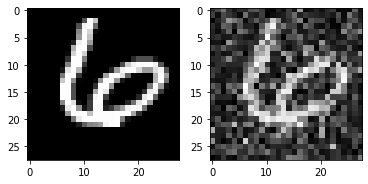

25  :  -0.8170584815130939 25
50  :  -0.8104889600396663 25
75  :  -0.8094176450074668 25
100  :  -0.8094176450074668 25
125  :  -0.804419836929513 25
150  :  -0.8043957718234827 25
175  :  -0.7829034200867977 25
200  :  -0.7826574196719611 25
225  :  -0.7826574196719611 25
250  :  -0.7826574196719611 25
275  :  -0.7826574196719611 25
300  :  -0.7826574196719611 25
325  :  -0.7826574196719611 25
350  :  -0.7826574196719611 25
375  :  -0.7826574196719611 25
400  :  -0.7826574196719611 25
425  :  -0.7113686372561705 25
450  :  -0.7098424277025341 25
475  :  -0.6635112766385189 25
500  :  -0.6635112766385189 25
525  :  -0.6635112766385189 25
550  :  -0.6181851695804863 25
575  :  -0.6177527949379436 25
600  :  -0.6177527949379436 25
625  :  -0.6177527949379436 25
650  :  -0.6177527949379436 25
675  :  -0.6177527949379436 25
700  :  -0.5913651571289693 25
725  :  -0.5908292165010622 25
750  :  -0.5908292165010622 25
775  :  -0.5908292165010622 25
800  :  -0.5870728772400635 25
825  :  -0.5

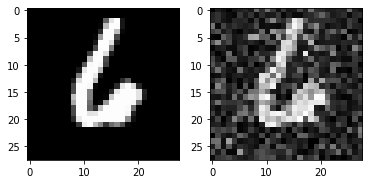

25  :  -0.7276428773641963 25
50  :  -0.7276428773641963 25
75  :  -0.7081069309065466 25
100  :  -0.6727768676162837 25
125  :  -0.6869880848422134 25
150  :  -0.6550157064377262 25
175  :  -0.6452701024420011 25
200  :  -0.6452701024420011 25
225  :  -0.6452701024420011 25
250  :  -0.6353786898793319 25
275  :  -0.6323292117673582 25
300  :  -0.6109890272662091 25
325  :  -0.5856480338490602 25
350  :  -0.5843953284291106 25
375  :  -0.5658004592701629 25
400  :  -0.5621058900381719 25
425  :  -0.5621058900381719 25
450  :  -0.5280882922275227 25
475  :  -0.4996139226857228 25
500  :  -0.48765595491534364 25
525  :  -0.46554872122474855 25
550  :  -0.4414005349468415 25
575  :  -0.4414005349468415 25
600  :  -0.4414005349468415 25
625  :  -0.44061729631804814 25
650  :  -0.43850946608295105 25
675  :  -0.4369954816566395 25
700  :  -0.426787873486407 25
725  :  -0.4201194134641538 25
750  :  -0.42002965860677133 25
775  :  -0.42002965860677133 25
800  :  -0.42002965860677133 25
825  

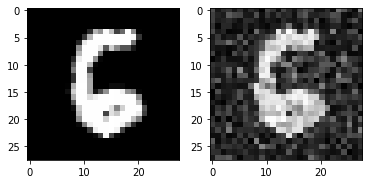

25  :  -1.2659440179508097 25
50  :  -0.9559487125536887 25
75  :  -0.8942311564860204 25
100  :  -0.8933183060220755 25
125  :  -0.8469969960856525 25
150  :  -0.86704788532565 25
175  :  -0.870888878389162 25
200  :  -0.870888878389162 25
225  :  -0.870888878389162 25
250  :  -0.870888878389162 25
275  :  -0.869697545763658 25
300  :  -0.8364731823185696 25
325  :  -0.8364731823185696 25
350  :  -0.8320185281008845 25
375  :  -0.8364731823185696 25
400  :  -0.8364731823185696 25
425  :  -0.8364731823185696 25
450  :  -0.8288368943193511 25
475  :  -0.792075161489505 25
500  :  -0.780315626363834 25
525  :  -0.7766456649239517 25
550  :  -0.7235446036189519 25
575  :  -0.7235446036189519 25
600  :  -0.7235446036189519 25
625  :  -0.7235446036189519 25
650  :  -0.7218920234842614 25
675  :  -0.7215868217746912 25
700  :  -0.7215868217746912 25
725  :  -0.7100598375450538 25
750  :  -0.6974574508111091 25
775  :  -0.6909188621755487 25
800  :  -0.6906358162279875 25
825  :  -0.690647044

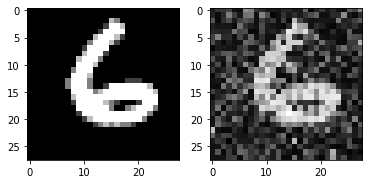

25  :  -0.8514350822675194 25
50  :  -0.8514350822675194 25
75  :  -0.8424333764810752 25
100  :  -0.8196933943022107 25
125  :  -0.7875428052260829 25
150  :  -0.7427471572930735 25
175  :  -0.7427471572930735 25
200  :  -0.7427471572930735 25
225  :  -0.7427471572930735 25
250  :  -0.7427471572930735 25
275  :  -0.7427471572930735 25
300  :  -0.707556305379142 25
325  :  -0.707556305379142 25
350  :  -0.6691878292348907 25
375  :  -0.6691878292348907 25
400  :  -0.6691878292348907 25
425  :  -0.6471345414645286 25
450  :  -0.6508154168309244 25
475  :  -0.6508154168309244 25
500  :  -0.6508154168309244 25
525  :  -0.6329810221478218 25
550  :  -0.6312237480847422 25
575  :  -0.6276195471082329 25
600  :  -0.6105644056284272 25
625  :  -0.6019153813297657 25
650  :  -0.5835076927859171 25
675  :  -0.5800273533352369 25
700  :  -0.5800273533352369 25
725  :  -0.5676148758629571 25
750  :  -0.5676148758629571 25
775  :  -0.5636763270337513 25
800  :  -0.5636763270337513 25
825  :  -0.56

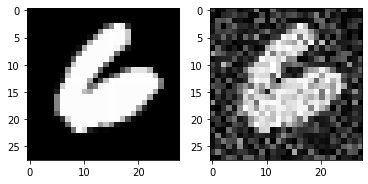

25  :  -0.7069444300847778 25
50  :  -0.6372282997737171 25
75  :  -0.6344604901279176 25
100  :  -0.6343347092590379 25
125  :  -0.6090862257514262 25
150  :  -0.5787468816410912 25
175  :  -0.5728453095561494 25
200  :  -0.5725764382051379 25
225  :  -0.5725764382051379 25
250  :  -0.5211304097143836 25
275  :  -0.5211304097143836 25
300  :  -0.5211304097143836 25
325  :  -0.5004755880817915 25
350  :  -0.4462803123408897 25
375  :  -0.44830840474260236 25
400  :  -0.44830840474260236 25
425  :  -0.42937912454098737 25
450  :  -0.42946012073672657 25
475  :  -0.41697480300008616 25
500  :  -0.41723961768533546 25
525  :  -0.41723961768533546 25
550  :  -0.40692735552498094 25
575  :  -0.40692735552498094 25
600  :  -0.4041077413095736 25
625  :  -0.40394667690940655 25
650  :  -0.40402843931511534 25
675  :  -0.40402843931511534 25
700  :  -0.3989477816794875 25
725  :  -0.3919533517372107 25
750  :  -0.3889818083918395 25
775  :  -0.3863805233271086 25
800  :  -0.3863805233271086 25

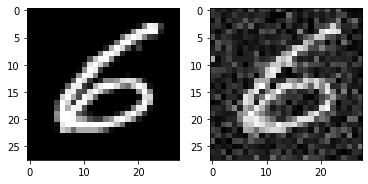

25  :  -0.7234792866462285 25
50  :  -0.6339630119555382 25
75  :  -0.6325224007614854 25
100  :  -0.6325224007614854 25
125  :  -0.6325224007614854 25
150  :  -0.625284849582056 25
175  :  -0.6207073660728524 25
200  :  -0.6207073660728524 25
225  :  -0.5890263885602889 25
250  :  -0.5638831106499578 25
275  :  -0.5639240990371399 25
300  :  -0.5468043268694711 25
325  :  -0.5349553407543279 25
350  :  -0.5047307184035055 25
375  :  -0.4935103850079888 25
400  :  -0.4935103850079888 25
425  :  -0.4935103850079888 25
450  :  -0.4935103850079888 25
475  :  -0.47502266352326405 25
500  :  -0.47135085595348647 25
525  :  -0.47135085595348647 25
550  :  -0.4643793318164726 25
575  :  -0.46357941143507964 25
600  :  -0.45509993207944976 25
625  :  -0.45048679266783376 25
650  :  -0.45048679266783376 25
675  :  -0.4459521609522611 25
700  :  -0.43801114942027264 25
725  :  -0.43626071307887704 25
750  :  -0.4362248305780363 25
775  :  -0.4328619696360273 25
800  :  -0.42944015735980234 25
82

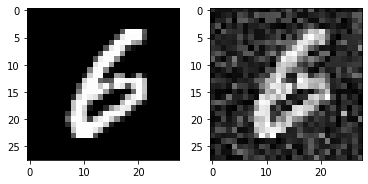

25  :  -1.2206862462415102 25
50  :  -1.1674126295849305 25
75  :  -0.9285450050102073 25
100  :  -0.921328418027294 25
125  :  -0.8598018443293793 25
150  :  -0.8506760292307294 25
175  :  -0.8755088748921211 25
200  :  -0.8498314122426731 25
225  :  -0.835211607335264 25
250  :  -0.7661284035083771 25
275  :  -0.7586299538095018 25
300  :  -0.7586299538095018 25
325  :  -0.7586299538095018 25
350  :  -0.7226866035686437 25
375  :  -0.7168003103971488 25
400  :  -0.7168003103971488 25
425  :  -0.7045763797235871 25
450  :  -0.7045763797235871 25
475  :  -0.7045763797235871 25
500  :  -0.7045763797235871 25
525  :  -0.7042905612475676 25
550  :  -0.6888280183107665 25
575  :  -0.6846934611665794 25
600  :  -0.6846934611665794 25
625  :  -0.670369468604727 25
650  :  -0.6624022901170452 25
675  :  -0.658213561334283 25
700  :  -0.6535110646831113 25
725  :  -0.6498682681934549 25
750  :  -0.6490055173723699 25
775  :  -0.6490459099865318 25
800  :  -0.6422457728806921 25
825  :  -0.6376

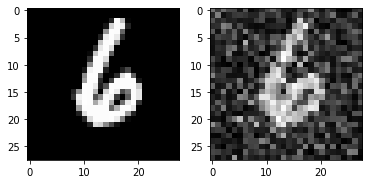

25  :  -0.7856788452689152 25
50  :  -0.7856788452689152 25
75  :  -0.7856788452689152 25
100  :  -0.6798038683401051 25
125  :  -0.6585102139297454 25
150  :  -0.6585102139297454 25
175  :  -0.6585102139297454 25
200  :  -0.6214407374934259 25
225  :  -0.6214407374934259 25
250  :  -0.6126517337370698 25
275  :  -0.5840775897856727 25
300  :  -0.5809834999374826 25
325  :  -0.5809834999374826 25
350  :  -0.5293653129102465 25
375  :  -0.5233304221203732 25
400  :  -0.5230236811912463 25
425  :  -0.5133052942588422 25
450  :  -0.5133052942588422 25
475  :  -0.5077093097053421 25
500  :  -0.5077093097053421 25
525  :  -0.49845217101785255 25
550  :  -0.4916337185098393 25
575  :  -0.47585809430214954 25
600  :  -0.4743899768208758 25
625  :  -0.4654115704398559 25
650  :  -0.46538125973201816 25
675  :  -0.461766824507434 25
700  :  -0.461766824507434 25
725  :  -0.461766824507434 25
750  :  -0.461766824507434 25
775  :  -0.4615811107491794 25
800  :  -0.46157628314758803 25
825  :  -0.

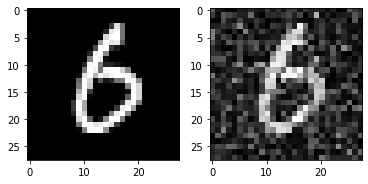

25  :  -0.9545070067422323 25
50  :  -0.9545070067422323 25
75  :  -0.9373387926418073 25
100  :  -0.8481958678017254 25
125  :  -0.8074277472539497 25
150  :  -0.8074277472539497 25
175  :  -0.8074277472539497 25
200  :  -0.8074277472539497 25
225  :  -0.8074277472539497 25
250  :  -0.8074277472539497 25
275  :  -0.8074277472539497 25
300  :  -0.8074277472539497 25
325  :  -0.8074277472539497 25
350  :  -0.7779537665842036 25
375  :  -0.7798839585359743 25
400  :  -0.7798839585359743 25
425  :  -0.7798839585359743 25
450  :  -0.7438756186078139 25
475  :  -0.7438756186078139 25
500  :  -0.7180403119460605 25
525  :  -0.7049354712061855 25
550  :  -0.7039364177064793 25
575  :  -0.7039364177064793 25
600  :  -0.7039364177064793 25
625  :  -0.6938759098408991 25
650  :  -0.6827999704819185 25
675  :  -0.6822069806176903 25
700  :  -0.6744739929019072 25
725  :  -0.6633905897082175 25
750  :  -0.6621765245913656 25
775  :  -0.6623471151727247 25
800  :  -0.6613408666844582 25
825  :  -0.

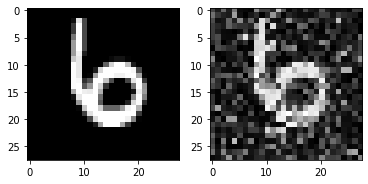

25  :  -0.7016301570811876 25
50  :  -0.7016301570811876 25
75  :  -0.6633002428149717 25
100  :  -0.6633002428149717 25
125  :  -0.6633002428149717 25
150  :  -0.6633002428149717 25
175  :  -0.6633002428149717 25
200  :  -0.6539309783062581 25
225  :  -0.6142178141566212 25
250  :  -0.5839256064022416 25
275  :  -0.5740892147064001 25
300  :  -0.5740892147064001 25
325  :  -0.5740892147064001 25
350  :  -0.5740892147064001 25
375  :  -0.5740892147064001 25
400  :  -0.5638647797892586 25
425  :  -0.5543415709260965 25
450  :  -0.5495810871176647 25
475  :  -0.5503347240933121 25
500  :  -0.5513415451472092 25
525  :  -0.5359231274696956 25
550  :  -0.5207286314854651 25
575  :  -0.5185161262434375 25
600  :  -0.5110857042502392 25
625  :  -0.497408837493165 25
650  :  -0.4973815536866444 25
675  :  -0.49140265143324025 25
700  :  -0.4914134622718056 25
725  :  -0.48477916598760484 25
750  :  -0.48264776005497834 25
775  :  -0.48244108440623223 25
800  :  -0.4820313441635493 25
825  :  

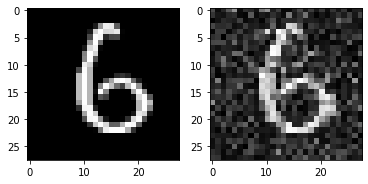

25  :  -0.723106238568826 25
50  :  -0.723106238568826 25
75  :  -0.6848284642230009 25
100  :  -0.5935915830982752 25
125  :  -0.5935915830982752 25
150  :  -0.5935915830982752 25
175  :  -0.5734704819580969 25
200  :  -0.5734704819580969 25
225  :  -0.5734704819580969 25
250  :  -0.5734704819580969 25
275  :  -0.4490504539776986 25
300  :  -0.4490504539776986 25
325  :  -0.4490504539776986 25
350  :  -0.4490504539776986 25
375  :  -0.4490504539776986 25
400  :  -0.4490504539776986 25
425  :  -0.4490504539776986 25
450  :  -0.4490504539776986 25
475  :  -0.4461641091359396 25
500  :  -0.4292453211615571 25
525  :  -0.4292453211615571 25
550  :  -0.4292453211615571 25
575  :  -0.4292453211615571 25
600  :  -0.4271745806588775 25
625  :  -0.4080277114804205 25
650  :  -0.3916611008386942 25
675  :  -0.38251349845617233 25
700  :  -0.3817058627729366 25
725  :  -0.3817058627729366 25
750  :  -0.3817058627729366 25
775  :  -0.3758359279840797 25
800  :  -0.37153262339236726 25
825  :  -0.

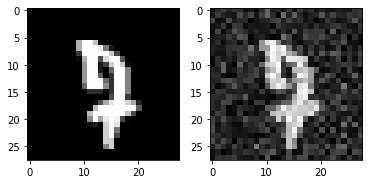

25  :  -0.6780348948710233 25
50  :  -0.6780348948710233 25
75  :  -0.6703237728334284 25
100  :  -0.6380548633128622 25
125  :  -0.6344080833739096 25
150  :  -0.6073366263575544 25
175  :  -0.5920234456611768 25
200  :  -0.5581205411796768 25
225  :  -0.5539217825947729 25
250  :  -0.5539217825947729 25
275  :  -0.5280560686673246 25
300  :  -0.5135530403571388 25
325  :  -0.5020441719664452 25
350  :  -0.5020441719664452 25
375  :  -0.5020441719664452 25
400  :  -0.49717581365526897 25
425  :  -0.49366854202039134 25
450  :  -0.4861195058584912 25
475  :  -0.48581447078771556 25
500  :  -0.48581447078771556 25
525  :  -0.48039529882149123 25
550  :  -0.4804799971404361 25
575  :  -0.4425358434777563 25
600  :  -0.437007601901777 25
625  :  -0.4322650172691149 25
650  :  -0.4321439131443743 25
675  :  -0.4216491213136935 25
700  :  -0.4098798050870863 25
725  :  -0.4098798050870863 25
750  :  -0.4058490596457135 25
775  :  -0.4058490596457135 25
800  :  -0.4039976436741136 25
825  : 

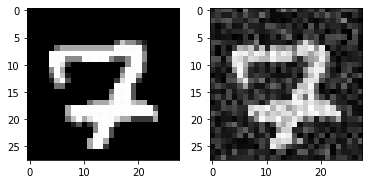

25  :  -0.7775827599422263 25
50  :  -0.6624880428772277 25
75  :  -0.7775827599422263 25
100  :  -0.7775827599422263 25
125  :  -0.7775827599422263 25
150  :  -0.7749880679637391 25
175  :  -0.7749880679637391 25
200  :  -0.7749880679637391 25
225  :  -0.7749880679637391 25
250  :  -0.7749880679637391 25
275  :  -0.6991217157693614 25
300  :  -0.6966635896217503 25
325  :  -0.6868331143204354 25
350  :  -0.6540155274692139 25
375  :  -0.648136404918864 25
400  :  -0.6348784224598616 25
425  :  -0.6348784224598616 25
450  :  -0.6200105583756554 25
475  :  -0.6133110731623426 25
500  :  -0.612504076824395 25
525  :  -0.5904619778813083 25
550  :  -0.5946467249268275 25
575  :  -0.5946467249268275 25
600  :  -0.5946467249268275 25
625  :  -0.5946467249268275 25
650  :  -0.5946467249268275 25
675  :  -0.5897830414542278 25
700  :  -0.5785973464068772 25
725  :  -0.5675897226485096 25
750  :  -0.5688095469156078 25
775  :  -0.5688095469156078 25
800  :  -0.5607623063929914 25
825  :  -0.55

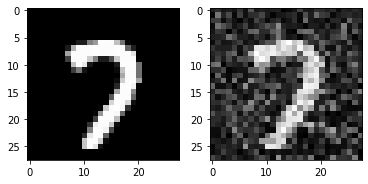

25  :  -1.2276523200996217 25
50  :  -1.2230312365715061 25
75  :  -0.9004479505739267 25
100  :  -0.9335847184480823 25
125  :  -0.9335847184480823 25
150  :  -0.9335847184480823 25
175  :  -0.9335847184480823 25
200  :  -0.9323270879962866 25
225  :  -0.9323270879962866 25
250  :  -0.9323270879962866 25
275  :  -0.8884967080702824 25
300  :  -0.8930913265549163 25
325  :  -0.8930913265549163 25
350  :  -0.8721446070979266 25
375  :  -0.8674344466517652 25
400  :  -0.8674344466517652 25
425  :  -0.8674344466517652 25
450  :  -0.8674344466517652 25
475  :  -0.8674344466517652 25
500  :  -0.8674344466517652 25
525  :  -0.8674344466517652 25
550  :  -0.8123501153059218 25
575  :  -0.8099418180058029 25
600  :  -0.8099418180058029 25
625  :  -0.8099418180058029 25
650  :  -0.7985698946628355 25
675  :  -0.7974018883212153 25
700  :  -0.7967868787039656 25
725  :  -0.7967868787039656 25
750  :  -0.7807299850966005 25
775  :  -0.7665872384467283 25
800  :  -0.7665872384467283 25
825  :  -0.

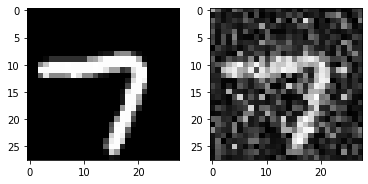

25  :  -1.0665898526424542 25
50  :  -1.03599522345222 25
75  :  -0.9171938192605915 25
100  :  -0.9208930725065143 25
125  :  -0.9169069801496232 25
150  :  -0.9174171437316203 25
175  :  -0.9174171437316203 25
200  :  -0.9174171437316203 25
225  :  -0.9131482524429413 25
250  :  -0.9131482524429413 25
275  :  -0.8697274005184406 25
300  :  -0.8452937434455869 25
325  :  -0.8368498324759379 25
350  :  -0.8368498324759379 25
375  :  -0.8368498324759379 25
400  :  -0.8368498324759379 25
425  :  -0.8275015685428524 25
450  :  -0.8237219101778086 25
475  :  -0.7674318063612524 25
500  :  -0.7674318063612524 25
525  :  -0.7674318063612524 25
550  :  -0.7674318063612524 25
575  :  -0.7674318063612524 25
600  :  -0.7589765705441609 25
625  :  -0.7581503712300282 25
650  :  -0.7581495656487061 25
675  :  -0.7518418361347237 25
700  :  -0.7518391802061191 25
725  :  -0.7422572566087209 25
750  :  -0.7419743705229869 25
775  :  -0.7407996525092728 25
800  :  -0.7383624249478853 25
825  :  -0.73

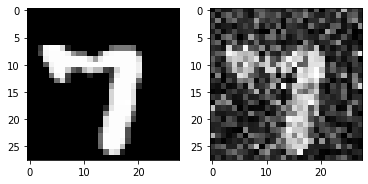

25  :  -0.6210579621674515 25
50  :  -0.5896057917041455 25
75  :  -0.5896057917041455 25
100  :  -0.5846715594538303 25
125  :  -0.5313191878250765 25
150  :  -0.48076586236263774 25
175  :  -0.48076586236263774 25
200  :  -0.48076586236263774 25
225  :  -0.4701732474733934 25
250  :  -0.44696554767059915 25
275  :  -0.432539907601869 25
300  :  -0.432539907601869 25
325  :  -0.40580816079989 25
350  :  -0.40580816079989 25
375  :  -0.38908012376736534 25
400  :  -0.38908012376736534 25
425  :  -0.38908012376736534 25
450  :  -0.3871103627934196 25
475  :  -0.37096003544709033 25
500  :  -0.37079453469208035 25
525  :  -0.36934197142268865 25
550  :  -0.36892637612332213 25
575  :  -0.3653128795163183 25
600  :  -0.35568571609679844 25
625  :  -0.35568571609679844 25
650  :  -0.34895842883349437 25
675  :  -0.34895842883349437 25
700  :  -0.34715701873684457 25
725  :  -0.34715701873684457 25
750  :  -0.34671694634721184 25
775  :  -0.34539870973778064 25
800  :  -0.34394244278760777 

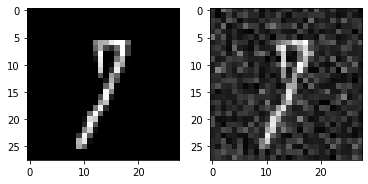

25  :  -0.7958255805055874 25
50  :  -0.7958255805055874 25
75  :  -0.7470561731721672 25
100  :  -0.7362236941450127 25
125  :  -0.7306902633042047 25
150  :  -0.7279640436589521 25
175  :  -0.7279640436589521 25
200  :  -0.7279640436589521 25
225  :  -0.7279640436589521 25
250  :  -0.6710016372670125 25
275  :  -0.6651040894142779 25
300  :  -0.6565879183498944 25
325  :  -0.6644498620708246 25
350  :  -0.6612967378439933 25
375  :  -0.6517468103634716 25
400  :  -0.6444009995154774 25
425  :  -0.6266948541247299 25
450  :  -0.6212564347345675 25
475  :  -0.6028163139908616 25
500  :  -0.6028163139908616 25
525  :  -0.6028163139908616 25
550  :  -0.5993074251558093 25
575  :  -0.5993074251558093 25
600  :  -0.5993074251558093 25
625  :  -0.5785569984711738 25
650  :  -0.5785569984711738 25
675  :  -0.5785569984711738 25
700  :  -0.5785569984711738 25
725  :  -0.5785569984711738 25
750  :  -0.5785569984711738 25
775  :  -0.5670728484996028 25
800  :  -0.5673018855189886 25
825  :  -0.

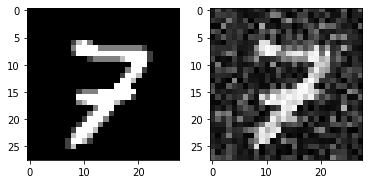

25  :  -0.790077595772922 25
50  :  -0.783334880539045 25
75  :  -0.7296992177134813 25
100  :  -0.705621062743014 25
125  :  -0.6778416065470465 25
150  :  -0.6746357667039753 25
175  :  -0.6717176111292531 25
200  :  -0.6604931598947315 25
225  :  -0.653696337578209 25
250  :  -0.6459852552116025 25
275  :  -0.6468486228202532 25
300  :  -0.6468486228202532 25
325  :  -0.6014628161879598 25
350  :  -0.5974246604317566 25
375  :  -0.5974246604317566 25
400  :  -0.5532572803289146 25
425  :  -0.5634969483117482 25
450  :  -0.5621320308509048 25
475  :  -0.5621320308509048 25
500  :  -0.5621320308509048 25
525  :  -0.5621320308509048 25
550  :  -0.5621320308509048 25
575  :  -0.5530656593336349 25
600  :  -0.5530656593336349 25
625  :  -0.5437705049875636 25
650  :  -0.5438425663772967 25
675  :  -0.5405695214162064 25
700  :  -0.5155539702755099 25
725  :  -0.5117898708687765 25
750  :  -0.503540132069907 25
775  :  -0.503540132069907 25
800  :  -0.49765710648316075 25
825  :  -0.49765

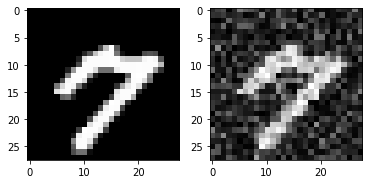

25  :  -0.7306562577824696 25
50  :  -0.7306562577824696 25
75  :  -0.7306562577824696 25
100  :  -0.7306562577824696 25
125  :  -0.7306562577824696 25
150  :  -0.7160268198974513 25
175  :  -0.7306562577824696 25
200  :  -0.7306562577824696 25
225  :  -0.7306562577824696 25
250  :  -0.7065990043041299 25
275  :  -0.7065990043041299 25
300  :  -0.6585844351880681 25
325  :  -0.6836720852459826 25
350  :  -0.5917011277946056 25
375  :  -0.5915079873996241 25
400  :  -0.5915079873996241 25
425  :  -0.5915079873996241 25
450  :  -0.5915079873996241 25
475  :  -0.5798813778888476 25
500  :  -0.5798813778888476 25
525  :  -0.5798813778888476 25
550  :  -0.5798813778888476 25
575  :  -0.5798813778888476 25
600  :  -0.5744712193087032 25
625  :  -0.5591966788862952 25
650  :  -0.5591966788862952 25
675  :  -0.5591966788862952 25
700  :  -0.553546782486595 25
725  :  -0.553546782486595 25
750  :  -0.553546782486595 25
775  :  -0.553546782486595 25
800  :  -0.553546782486595 25
825  :  -0.54913

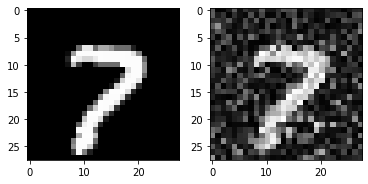

25  :  -0.8302127286288958 25
50  :  -0.8302127286288958 25
75  :  -0.8302127286288958 25
100  :  -0.8302127286288958 25
125  :  -0.8302127286288958 25
150  :  -0.8302127286288958 25
175  :  -0.8302127286288958 25
200  :  -0.8302127286288958 25
225  :  -0.8302127286288958 25
250  :  -0.8302127286288958 25
275  :  -0.8302127286288958 25
300  :  -0.8182557669206942 25
325  :  -0.8182557669206942 25
350  :  -0.8182557669206942 25
375  :  -0.8182557669206942 25
400  :  -0.7977439968045708 25
425  :  -0.7955847826892286 25
450  :  -0.7942773687339082 25
475  :  -0.7665742686945176 25
500  :  -0.7267746280396576 25
525  :  -0.7259131715101887 25
550  :  -0.7259131715101887 25
575  :  -0.7259131715101887 25
600  :  -0.7168426367975695 25
625  :  -0.7007565766307937 25
650  :  -0.6947551567295511 25
675  :  -0.6986999994569272 25
700  :  -0.6938068427975281 25
725  :  -0.6900402155059815 25
750  :  -0.6568432746556545 25
775  :  -0.6516573600994746 25
800  :  -0.6404361544112638 25
825  :  -0.

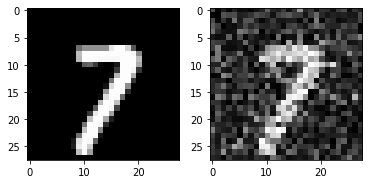

25  :  -0.712595093194043 25
50  :  -0.712595093194043 25
75  :  -0.7153545527896676 25
100  :  -0.7153545527896676 25
125  :  -0.7153545527896676 25
150  :  -0.7153545527896676 25
175  :  -0.6786551222599488 25
200  :  -0.6513896798672938 25
225  :  -0.6299877998664702 25
250  :  -0.6299823056941247 25
275  :  -0.6279512525204314 25
300  :  -0.6052964703232089 25
325  :  -0.6048805235767996 25
350  :  -0.6048805235767996 25
375  :  -0.6048805235767996 25
400  :  -0.6048805235767996 25
425  :  -0.5454912634450066 25
450  :  -0.5454912634450066 25
475  :  -0.5454912634450066 25
500  :  -0.5454912634450066 25
525  :  -0.5454912634450066 25
550  :  -0.5454912634450066 25
575  :  -0.5454912634450066 25
600  :  -0.5362196519040954 25
625  :  -0.5336233024963875 25
650  :  -0.5146302897812478 25
675  :  -0.5157700153839837 25
700  :  -0.5157700153839837 25
725  :  -0.5123342824866337 25
750  :  -0.5113102551508453 25
775  :  -0.5113102551508453 25
800  :  -0.5094085346350481 25
825  :  -0.50

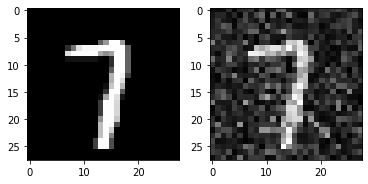

25  :  -0.8086316470110588 25
50  :  -0.7978672076845685 25
75  :  -0.7685095339843744 25
100  :  -0.7731446990698125 25
125  :  -0.7731446990698125 25
150  :  -0.7731446990698125 25
175  :  -0.7731446990698125 25
200  :  -0.7731446990698125 25
225  :  -0.7731446990698125 25
250  :  -0.7472745129015486 25
275  :  -0.730834387918003 25
300  :  -0.7593250251742427 25
325  :  -0.7447563715150327 25
350  :  -0.6972780897259319 25
375  :  -0.6978951600028842 25
400  :  -0.6840452515014699 25
425  :  -0.6792664971591584 25
450  :  -0.6849725662969968 25
475  :  -0.6742532924788465 25
500  :  -0.6723961378944883 25
525  :  -0.6543386534807825 25
550  :  -0.6571613923283035 25
575  :  -0.6571613923283035 25
600  :  -0.6281126827761998 25
625  :  -0.6278328547514931 25
650  :  -0.5931157509430511 25
675  :  -0.5931157509430511 25
700  :  -0.5931157509430511 25
725  :  -0.5930016702382404 25
750  :  -0.5931157509430511 25
775  :  -0.5931157509430511 25
800  :  -0.5739803315603007 25
825  :  -0.5

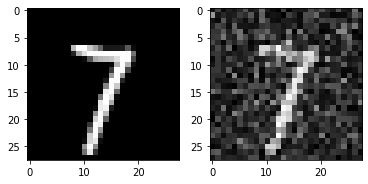

25  :  -0.7436815127999357 25
50  :  -0.6881212358267712 25
75  :  -0.6587176876019618 25
100  :  -0.6666583653634657 25
125  :  -0.6646165129836168 25
150  :  -0.6702836771137435 25
175  :  -0.6661025475828519 25
200  :  -0.6498921443910539 25
225  :  -0.642884051709294 25
250  :  -0.6378325695912279 25
275  :  -0.6302352294981173 25
300  :  -0.6253229886321301 25
325  :  -0.6143530002505047 25
350  :  -0.5946990335239961 25
375  :  -0.597185098021521 25
400  :  -0.5785324046068696 25
425  :  -0.5734051966630491 25
450  :  -0.5741420098457357 25
475  :  -0.5466133333363958 25
500  :  -0.555867414946015 25
525  :  -0.555867414946015 25
550  :  -0.555867414946015 25
575  :  -0.5391800457221139 25
600  :  -0.5388126417733556 25
625  :  -0.53459127024167 25
650  :  -0.5349840315200727 25
675  :  -0.5135909369286553 25
700  :  -0.521989926625203 25
725  :  -0.516021059662064 25
750  :  -0.5168250059789616 25
775  :  -0.5168250059789616 25
800  :  -0.5137250841222653 25
825  :  -0.514217410

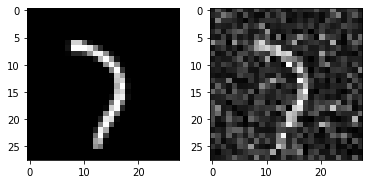

25  :  -1.6114275621892111 25
50  :  -1.6114275621892111 25
75  :  -1.6114275621892111 25
100  :  -1.5987473583249387 25
125  :  -1.560711799537714 25
150  :  -1.5078407360678745 25
175  :  -1.3969050731721728 25
200  :  -1.3969050731721728 25
225  :  -1.3969050731721728 25
250  :  -1.3969050731721728 25
275  :  -1.3969050731721728 25
300  :  -1.3969050731721728 25
325  :  -1.3790196777490218 25
350  :  -1.3789857058970265 25
375  :  -1.3789857058970265 25
400  :  -1.3316564063854135 25
425  :  -1.3316564063854135 25
450  :  -1.3316564063854135 25
475  :  -1.3316564063854135 25
500  :  -1.3316564063854135 25
525  :  -1.3278734585669119 25
550  :  -1.3278734585669119 25
575  :  -1.3278734585669119 25
600  :  -1.3275742925689409 25
625  :  -1.3275742925689409 25
650  :  -1.3275558522439732 25
675  :  -1.3275239656367634 25
700  :  -1.3196424372380564 25
725  :  -1.3178606360103635 25
750  :  -1.3178606360103635 25
775  :  -1.3168452840445628 25
800  :  -1.313555735864489 25
825  :  -1.31

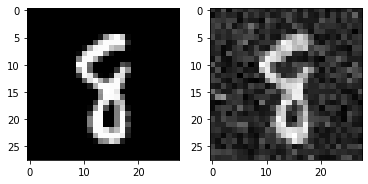

25  :  -1.6627091428087963 25
50  :  -1.6627091428087963 25
75  :  -1.5741046878476797 25
100  :  -1.5741046878476797 25
125  :  -1.476423333625395 25
150  :  -1.476423333625395 25
175  :  -1.4281498172458897 25
200  :  -1.4281498172458897 25
225  :  -1.3693593339124313 25
250  :  -1.3693593339124313 25
275  :  -1.3693593339124313 25
300  :  -1.3693593339124313 25
325  :  -1.3674389027409566 25
350  :  -1.3674352450175769 25
375  :  -1.347580251833829 25
400  :  -1.347344073027526 25
425  :  -1.347344073027526 25
450  :  -1.347344073027526 25
475  :  -1.3443001295723178 25
500  :  -1.3432967116418744 25
525  :  -1.3391937277624608 25
550  :  -1.3378184306666856 25
575  :  -1.328009015479813 25
600  :  -1.328009015479813 25
625  :  -1.328009015479813 25
650  :  -1.3240384351238634 25
675  :  -1.3240384351238634 25
700  :  -1.3217417739102646 25
725  :  -1.3217417739102646 25
750  :  -1.3217417739102646 25
775  :  -1.3206063013403206 25
800  :  -1.3190734633468386 25
825  :  -1.319073463

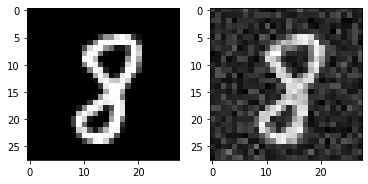

25  :  -1.617741990475717 25
50  :  -1.542503564617654 25
75  :  -1.48419259298332 25
100  :  -1.4809013277786254 25
125  :  -1.4433453274159338 25
150  :  -1.419058747304712 25
175  :  -1.4137069350641138 25
200  :  -1.4070957937427802 25
225  :  -1.3981095897375475 25
250  :  -1.3798300096075446 25
275  :  -1.3758270322817512 25
300  :  -1.3453775576952098 25
325  :  -1.3389060812193003 25
350  :  -1.3389060812193003 25
375  :  -1.3294758761313679 25
400  :  -1.3271786417535485 25
425  :  -1.3271786417535485 25
450  :  -1.321703690858118 25
475  :  -1.3145509577448764 25
500  :  -1.30846970879165 25
525  :  -1.30846970879165 25
550  :  -1.3045596106397364 25
575  :  -1.3045596106397364 25
600  :  -1.3028172877520516 25
625  :  -1.3010271886427267 25
650  :  -1.30064095612498 25
675  :  -1.2997790346323812 25
700  :  -1.298044861192293 25
725  :  -1.2963803239367526 25
750  :  -1.2953999220925367 25
775  :  -1.2936784557882683 25
800  :  -1.2916905557052858 25
825  :  -1.2890269092326

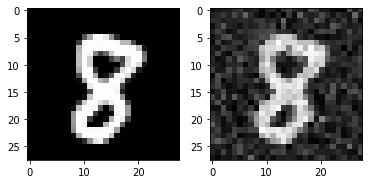

25  :  -1.6369507514351045 25
50  :  -1.6161176372812138 25
75  :  -1.5543773738020237 25
100  :  -1.5480083269542104 25
125  :  -1.5480083269542104 25
150  :  -1.5316508081412443 25
175  :  -1.504229768591416 25
200  :  -1.472087347600213 25
225  :  -1.4558783472593944 25
250  :  -1.3842136268797005 25
275  :  -1.3842136268797005 25
300  :  -1.3842136268797005 25
325  :  -1.3842136268797005 25
350  :  -1.3759803346612864 25
375  :  -1.3759803346612864 25
400  :  -1.3740111696073072 25
425  :  -1.3740111696073072 25
450  :  -1.3740111696073072 25
475  :  -1.3498442405053144 25
500  :  -1.3491664036916873 25
525  :  -1.3334237105218119 25
550  :  -1.3334237105218119 25
575  :  -1.3334237105218119 25
600  :  -1.3165604662353836 25
625  :  -1.3165601349147518 25
650  :  -1.3064403190507752 25
675  :  -1.3063698752105495 25
700  :  -1.3063698752105495 25
725  :  -1.3048474218245878 25
750  :  -1.3048474218245878 25
775  :  -1.3048474218245878 25
800  :  -1.3006639362772319 25
825  :  -1.29

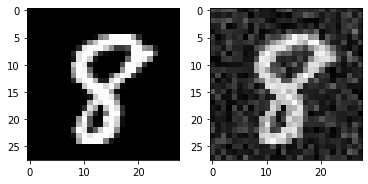

25  :  -1.696114143080008 25
50  :  -1.5914403113480582 25
75  :  -1.5466042475453674 25
100  :  -1.5465846345073528 25
125  :  -1.5269731840405405 25
150  :  -1.5010136202334832 25
175  :  -1.43839817579342 25
200  :  -1.43839817579342 25
225  :  -1.43839817579342 25
250  :  -1.415154414583549 25
275  :  -1.4134979327112602 25
300  :  -1.4134979327112602 25
325  :  -1.3896013118591635 25
350  :  -1.3844687335567278 25
375  :  -1.3843867325246304 25
400  :  -1.3843867325246304 25
425  :  -1.3764492762540723 25
450  :  -1.3621848440661202 25
475  :  -1.3621848440661202 25
500  :  -1.3559719439099283 25
525  :  -1.3486612678555372 25
550  :  -1.3486612678555372 25
575  :  -1.347635647862933 25
600  :  -1.3471277668980288 25
625  :  -1.3466097013493363 25
650  :  -1.3454809810275066 25
675  :  -1.3425258171580636 25
700  :  -1.3425258171580636 25
725  :  -1.3410729834407842 25
750  :  -1.3401653116896162 25
775  :  -1.3401653116896162 25
800  :  -1.3395829460846997 25
825  :  -1.338283169

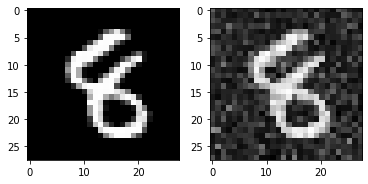

25  :  -1.6663103461538202 25
50  :  -1.6663103461538202 25
75  :  -1.5578913178938618 25
100  :  -1.5237671218655229 25
125  :  -1.5168075278113469 25
150  :  -1.5168075278113469 25
175  :  -1.5168075278113469 25
200  :  -1.491370452383688 25
225  :  -1.455197351224815 25
250  :  -1.438369175748892 25
275  :  -1.4285726355832153 25
300  :  -1.4266913908689398 25
325  :  -1.4261175659871719 25
350  :  -1.4105860875847769 25
375  :  -1.3997937432596421 25
400  :  -1.379572642477981 25
425  :  -1.379572642477981 25
450  :  -1.3698061729598099 25
475  :  -1.3697738602438982 25
500  :  -1.3604684950195163 25
525  :  -1.3535585318847916 25
550  :  -1.34524507707629 25
575  :  -1.3422307642988534 25
600  :  -1.3421625350878077 25
625  :  -1.333591270273332 25
650  :  -1.3334787145393676 25
675  :  -1.3334786453879104 25
700  :  -1.3279279735784024 25
725  :  -1.3274593525631715 25
750  :  -1.3247635583262363 25
775  :  -1.3229392275344682 25
800  :  -1.3229392275344682 25
825  :  -1.32106050

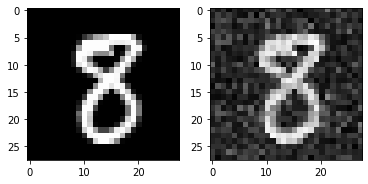

25  :  -1.6369886011568044 25
50  :  -1.5891770638991796 25
75  :  -1.524613330445339 25
100  :  -1.524613330445339 25
125  :  -1.5041428205207037 25
150  :  -1.4604125700545367 25
175  :  -1.456286610597521 25
200  :  -1.4553882796778066 25
225  :  -1.4023339447153873 25
250  :  -1.4023252190327176 25
275  :  -1.3991337443596188 25
300  :  -1.3991337443596188 25
325  :  -1.3845445299951784 25
350  :  -1.3765814554124698 25
375  :  -1.3754851461664734 25
400  :  -1.3546944910829495 25
425  :  -1.3546944910829495 25
450  :  -1.3502237510683628 25
475  :  -1.3502223952996957 25
500  :  -1.3502223952996957 25
525  :  -1.3493927338882192 25
550  :  -1.3350948758611878 25
575  :  -1.3350826321382228 25
600  :  -1.332340274241056 25
625  :  -1.32370812281121 25
650  :  -1.3236968320950435 25
675  :  -1.3191940945165066 25
700  :  -1.3115206362949938 25
725  :  -1.3115206362949938 25
750  :  -1.3115206362949938 25
775  :  -1.3047064300994298 25
800  :  -1.3047064300994298 25
825  :  -1.302420

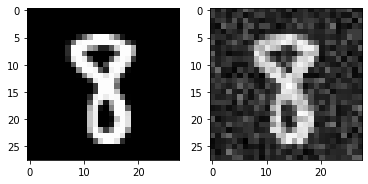

25  :  -0.761077896024511 25
50  :  -0.761077896024511 25
75  :  -0.761077896024511 25
100  :  -0.761077896024511 25
125  :  -0.761077896024511 25
150  :  -0.7199486924715415 25
175  :  -0.708499259475518 25
200  :  -0.708499259475518 25
225  :  -0.708499259475518 25
250  :  -0.708499259475518 25
275  :  -0.708499259475518 25
300  :  -0.6817486823252152 25
325  :  -0.6817486823252152 25
350  :  -0.6817486823252152 25
375  :  -0.6652781450758594 25
400  :  -0.6519902102690645 25
425  :  -0.6519902102690645 25
450  :  -0.6519902102690645 25
475  :  -0.6519902102690645 25
500  :  -0.6454054763456145 25
525  :  -0.6455723854022608 25
550  :  -0.6374357578415599 25
575  :  -0.6324147866611591 25
600  :  -0.6251248358219006 25
625  :  -0.6152583707502741 25
650  :  -0.6152422833199538 25
675  :  -0.6152422833199538 25
700  :  -0.608958291438741 25
725  :  -0.6000573705478738 25
750  :  -0.5977235108353167 25
775  :  -0.5940855554639124 25
800  :  -0.5879999184883802 25
825  :  -0.58759800907

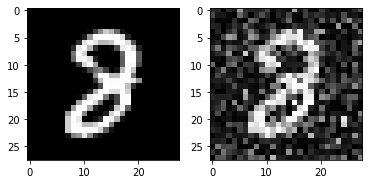

25  :  -1.5212659476365427 25
50  :  -1.5212659476365427 25
75  :  -1.5212659476365427 25
100  :  -1.5212659476365427 25
125  :  -1.5212659476365427 25
150  :  -1.4730721250876018 25
175  :  -1.4373789568503428 25
200  :  -1.4332768926918902 25
225  :  -1.405763023740077 25
250  :  -1.3962149914476836 25
275  :  -1.3962139805525302 25
300  :  -1.3927875309149467 25
325  :  -1.3837311574071682 25
350  :  -1.3723325717440598 25
375  :  -1.3699469261558095 25
400  :  -1.3699113935884077 25
425  :  -1.3603680192042171 25
450  :  -1.3565029748020236 25
475  :  -1.3565013271342443 25
500  :  -1.3565013271342443 25
525  :  -1.3551673279770502 25
550  :  -1.3442762742785013 25
575  :  -1.3442762742785013 25
600  :  -1.3396231717474603 25
625  :  -1.3375987759979537 25
650  :  -1.3375987759979537 25
675  :  -1.3362896534296862 25
700  :  -1.3362896534296862 25
725  :  -1.3332358472196328 25
750  :  -1.329772700813647 25
775  :  -1.3260877331701755 25
800  :  -1.325844906873471 25
825  :  -1.325

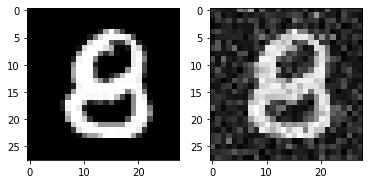

25  :  -1.6238288041089552 25
50  :  -1.5956262152707137 25
75  :  -1.5769595983784201 25
100  :  -1.5167362883412756 25
125  :  -1.4421015534247155 25
150  :  -1.3822695286066735 25
175  :  -1.3822695286066735 25
200  :  -1.3822695286066735 25
225  :  -1.3822695286066735 25
250  :  -1.3822695286066735 25
275  :  -1.3822695286066735 25
300  :  -1.3822695286066735 25
325  :  -1.3815962187855577 25
350  :  -1.3808797661888326 25
375  :  -1.3727498812415055 25
400  :  -1.3726210161576153 25
425  :  -1.3698272157129159 25
450  :  -1.3698272157129159 25
475  :  -1.35434810899768 25
500  :  -1.3415540183747092 25
525  :  -1.3415540183747092 25
550  :  -1.3330233905216484 25
575  :  -1.3328978111244485 25
600  :  -1.3235293466676703 25
625  :  -1.3209112419190325 25
650  :  -1.3179570631720585 25
675  :  -1.3179570631720585 25
700  :  -1.315698009881541 25
725  :  -1.315698009881541 25
750  :  -1.3056606561235005 25
775  :  -1.3034944478687778 25
800  :  -1.3034944478687778 25
825  :  -1.3034

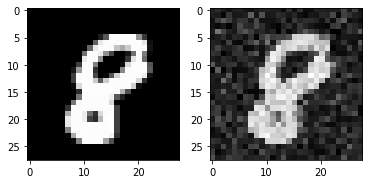

25  :  -1.5273854013715438 25
50  :  -1.5273854013715438 25
75  :  -1.5273854013715438 25
100  :  -1.4584811965967097 25
125  :  -1.4584811965967097 25
150  :  -1.4584811965967097 25
175  :  -1.4584811965967097 25
200  :  -1.4584811965967097 25
225  :  -1.438446447893658 25
250  :  -1.435192756744076 25
275  :  -1.4100424154053512 25
300  :  -1.394703088580941 25
325  :  -1.3687170115001885 25
350  :  -1.3569086338191672 25
375  :  -1.3569086338191672 25
400  :  -1.350415238589199 25
425  :  -1.3501055340773114 25
450  :  -1.335222570779944 25
475  :  -1.3336637747623772 25
500  :  -1.3270064861351019 25
525  :  -1.3215150021238276 25
550  :  -1.3188671957096911 25
575  :  -1.31134657165705 25
600  :  -1.3113423423417845 25
625  :  -1.3096703080339225 25
650  :  -1.3079188837476337 25
675  :  -1.3009262519086033 25
700  :  -1.3005812629737823 25
725  :  -1.2983209862635627 25
750  :  -1.2949690824562452 25
775  :  -1.2949690824562452 25
800  :  -1.2897530130605146 25
825  :  -1.2897530

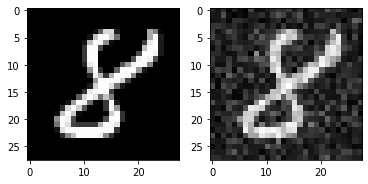

25  :  -1.537407692004358 25
50  :  -1.537407692004358 25
75  :  -1.537407692004358 25
100  :  -1.521932510028905 25
125  :  -1.4813671126821322 25
150  :  -1.4740728818357123 25
175  :  -1.4692215156392918 25
200  :  -1.4381090252083815 25
225  :  -1.4359172893838323 25
250  :  -1.4198341538116392 25
275  :  -1.4013288178408794 25
300  :  -1.3747941693090429 25
325  :  -1.3738766805066218 25
350  :  -1.3216681548958986 25
375  :  -1.3216681548958986 25
400  :  -1.320038956346671 25
425  :  -1.320038956346671 25
450  :  -1.320038956346671 25
475  :  -1.320038956346671 25
500  :  -1.320038956346671 25
525  :  -1.3190530652061323 25
550  :  -1.3147046131955422 25
575  :  -1.310571448058396 25
600  :  -1.305303415322157 25
625  :  -1.304344092430024 25
650  :  -1.300481404712344 25
675  :  -1.297861324482605 25
700  :  -1.2971821377151598 25
725  :  -1.2936645735368084 25
750  :  -1.289568844156689 25
775  :  -1.289568844156689 25
800  :  -1.2866609648042409 25
825  :  -1.2866609648042409

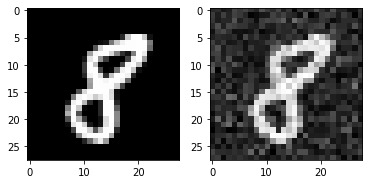

25  :  -0.7668173650402614 25
50  :  -0.758666316166859 25
75  :  -0.7097847042052992 25
100  :  -0.7097847042052992 25
125  :  -0.7097847042052992 25
150  :  -0.7097847042052992 25
175  :  -0.7097847042052992 25
200  :  -0.7090583170319444 25
225  :  -0.7090583170319444 25
250  :  -0.6763568399820168 25
275  :  -0.6763568399820168 25
300  :  -0.6763568399820168 25
325  :  -0.6717658974411171 25
350  :  -0.6594566394298758 25
375  :  -0.6573147743296073 25
400  :  -0.6573147743296073 25
425  :  -0.6573147743296073 25
450  :  -0.6555712026703753 25
475  :  -0.6461552451365953 25
500  :  -0.6425953396830701 25
525  :  -0.6425953396830701 25
550  :  -0.6425953396830701 25
575  :  -0.6346065064469035 25
600  :  -0.6341330141378418 25
625  :  -0.6258032001711693 25
650  :  -0.608724765215636 25
675  :  -0.6131085109428736 25
700  :  -0.6131085109428736 25
725  :  -0.5950926079140522 25
750  :  -0.5928330127005406 25
775  :  -0.5914024314239896 25
800  :  -0.574993640031298 25
825  :  -0.564

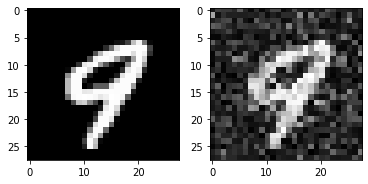

25  :  -0.7791183350441961 25
50  :  -0.7791183350441961 25
75  :  -0.7757178031999967 25
100  :  -0.7757178031999967 25
125  :  -0.7757178031999967 25
150  :  -0.7757178031999967 25
175  :  -0.7757178031999967 25
200  :  -0.7757178031999967 25
225  :  -0.7757178031999967 25
250  :  -0.7757178031999967 25
275  :  -0.7757178031999967 25
300  :  -0.7757178031999967 25
325  :  -0.7757178031999967 25
350  :  -0.7757178031999967 25
375  :  -0.7757178031999967 25
400  :  -0.7757178031999967 25
425  :  -0.7757178031999967 25
450  :  -0.7757178031999967 25
475  :  -0.7757178031999967 25
500  :  -0.7757178031999967 25
525  :  -0.7757178031999967 25
550  :  -0.7757178031999967 25
575  :  -0.7757178031999967 25
600  :  -0.7757178031999967 25
625  :  -0.7757178031999967 25
650  :  -0.7757178031999967 25
675  :  -0.7757178031999967 25
700  :  -0.7757178031999967 25
725  :  -0.7757178031999967 25
750  :  -0.7757178031999967 25
775  :  -0.7757178031999967 25
800  :  -0.7757178031999967 25
Time:  39.0

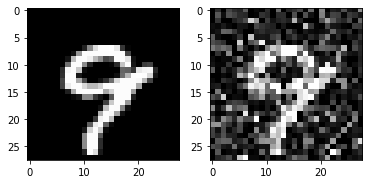

25  :  -0.6826164276897893 25
50  :  -0.6826164276897893 25
75  :  -0.6753824438391596 25
100  :  -0.6078715505048873 25
125  :  -0.5907859283244028 25
150  :  -0.5779692492097281 25
175  :  -0.5750035933087765 25
200  :  -0.5750035933087765 25
225  :  -0.5512068713123519 25
250  :  -0.5678465075387 25
275  :  -0.5398951063207451 25
300  :  -0.5070201081853308 25
325  :  -0.524739729003693 25
350  :  -0.524739729003693 25
375  :  -0.5234374168865967 25
400  :  -0.5137617843291059 25
425  :  -0.5025923365789371 25
450  :  -0.5025923365789371 25
475  :  -0.4832734380094392 25
500  :  -0.45342625013690085 25
525  :  -0.45378897074656743 25
550  :  -0.45378897074656743 25
575  :  -0.45378897074656743 25
600  :  -0.45378897074656743 25
625  :  -0.44531915916891207 25
650  :  -0.44460026236865324 25
675  :  -0.4354917929214883 25
700  :  -0.42502783745471073 25
725  :  -0.42502783745471073 25
750  :  -0.42502783745471073 25
775  :  -0.42502783745471073 25
800  :  -0.4166888785616786 25
825  

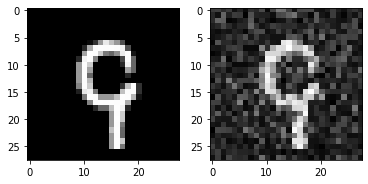

25  :  -0.8627405838907254 25
50  :  -0.8627405838907254 25
75  :  -0.7688308798210071 25
100  :  -0.7217136504913815 25
125  :  -0.7079093864715138 25
150  :  -0.6948166380281666 25
175  :  -0.6948166380281666 25
200  :  -0.6713563099508029 25
225  :  -0.6750610497396907 25
250  :  -0.595781248133989 25
275  :  -0.5954928208704429 25
300  :  -0.5954928208704429 25
325  :  -0.5954928208704429 25
350  :  -0.5866789011379503 25
375  :  -0.5870215943074308 25
400  :  -0.5849263562595703 25
425  :  -0.5849263562595703 25
450  :  -0.5601410644999858 25
475  :  -0.559597702452997 25
500  :  -0.559597702452997 25
525  :  -0.559597702452997 25
550  :  -0.5491703680498645 25
575  :  -0.5394217499142948 25
600  :  -0.5394217499142948 25
625  :  -0.5394217499142948 25
650  :  -0.5394217499142948 25
675  :  -0.5359321122714635 25
700  :  -0.5359319235492896 25
725  :  -0.5351460482399888 25
750  :  -0.5251874913653645 25
775  :  -0.5166434863635816 25
800  :  -0.5166434863635816 25
825  :  -0.5166

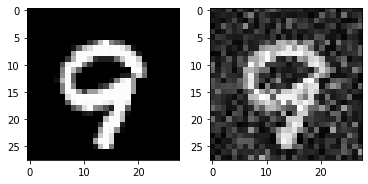

25  :  -0.7467820363802136 25
50  :  -0.722057022204952 25
75  :  -0.716259720034244 25
100  :  -0.6910151460253509 25
125  :  -0.6738473500791189 25
150  :  -0.6738473500791189 25
175  :  -0.6221180773597219 25
200  :  -0.6209267490955579 25
225  :  -0.6209267490955579 25
250  :  -0.6209267490955579 25
275  :  -0.6209267490955579 25
300  :  -0.6209267490955579 25
325  :  -0.6209267490955579 25
350  :  -0.5806569858891426 25
375  :  -0.5599677965928815 25
400  :  -0.5599677965928815 25
425  :  -0.5599677965928815 25
450  :  -0.5215646256869477 25
475  :  -0.5237288083259248 25
500  :  -0.5237288083259248 25
525  :  -0.5237288083259248 25
550  :  -0.5014745623075466 25
575  :  -0.5014745623075466 25
600  :  -0.48471837045702093 25
625  :  -0.4847840192912959 25
650  :  -0.4820638128467689 25
675  :  -0.4785760668047455 25
700  :  -0.45937246355591044 25
725  :  -0.45937246355591044 25
750  :  -0.45937246355591044 25
775  :  -0.45937246355591044 25
800  :  -0.45937246355591044 25
825  : 

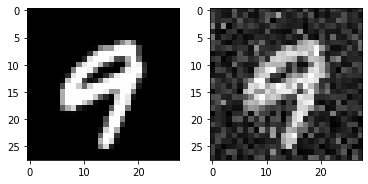

25  :  -0.6535804995706198 25
50  :  -0.6535804995706198 25
75  :  -0.6535804995706198 25
100  :  -0.6535804995706198 25
125  :  -0.6535804995706198 25
150  :  -0.6346372147568109 25
175  :  -0.5947677316549234 25
200  :  -0.5856611394649978 25
225  :  -0.5372335063347677 25
250  :  -0.5373233228339018 25
275  :  -0.5373233228339018 25
300  :  -0.5373233228339018 25
325  :  -0.5373233228339018 25
350  :  -0.5373233228339018 25
375  :  -0.5373233228339018 25
400  :  -0.5373233228339018 25
425  :  -0.5179557316042473 25
450  :  -0.5146057678426275 25
475  :  -0.5080352817341731 25
500  :  -0.4964554036342004 25
525  :  -0.4860752087930027 25
550  :  -0.48196786560409266 25
575  :  -0.4823017454120835 25
600  :  -0.44434578040817496 25
625  :  -0.43591068338949046 25
650  :  -0.4323530219571192 25
675  :  -0.4323530219571192 25
700  :  -0.4243802329155746 25
725  :  -0.42136448721418307 25
750  :  -0.4143320157616641 25
775  :  -0.4143320157616641 25
800  :  -0.4143320157616641 25
825  : 

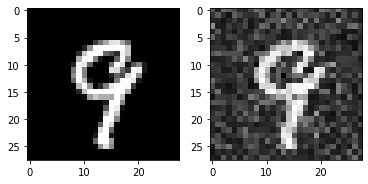

25  :  -0.7294558316484534 25
50  :  -0.7294558316484534 25
75  :  -0.6941086686116451 25
100  :  -0.6941086686116451 25
125  :  -0.6941086686116451 25
150  :  -0.6448980614876574 25
175  :  -0.6401389584892136 25
200  :  -0.630665561913049 25
225  :  -0.630665561913049 25
250  :  -0.630665561913049 25
275  :  -0.6015972335538597 25
300  :  -0.6015972335538597 25
325  :  -0.6015972335538597 25
350  :  -0.566533694721947 25
375  :  -0.5694834176597707 25
400  :  -0.5694834176597707 25
425  :  -0.5694834176597707 25
450  :  -0.5694834176597707 25
475  :  -0.5694834176597707 25
500  :  -0.5694834176597707 25
525  :  -0.5573076956164804 25
550  :  -0.5573076956164804 25
575  :  -0.5473927596221928 25
600  :  -0.5473927596221928 25
625  :  -0.5473927596221928 25
650  :  -0.5473927596221928 25
675  :  -0.5443151148677574 25
700  :  -0.5473927596221928 25
725  :  -0.5473927596221928 25
750  :  -0.5473927596221928 25
775  :  -0.5473927596221928 25
800  :  -0.5432144721599677 25
825  :  -0.5365

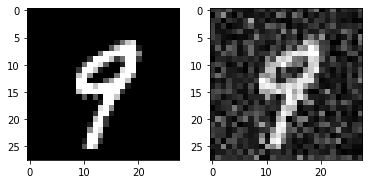

25  :  -0.7024257694587404 25
50  :  -0.7024257694587404 25
75  :  -0.6859849804423981 25
100  :  -0.6859849804423981 25
125  :  -0.6792107650564754 25
150  :  -0.5509726889900275 25
175  :  -0.5259538167021212 25
200  :  -0.5228068961057615 25
225  :  -0.5228068961057615 25
250  :  -0.5228068961057615 25
275  :  -0.5179219897659382 25
300  :  -0.5179219897659382 25
325  :  -0.5179219897659382 25
350  :  -0.5179219897659382 25
375  :  -0.501659270095609 25
400  :  -0.501659270095609 25
425  :  -0.501659270095609 25
450  :  -0.46528030271235155 25
475  :  -0.46528030271235155 25
500  :  -0.46528030271235155 25
525  :  -0.46528030271235155 25
550  :  -0.45892391295373147 25
575  :  -0.4561001783736689 25
600  :  -0.4481041731666514 25
625  :  -0.44328621316440187 25
650  :  -0.44129024387164006 25
675  :  -0.43274640954748345 25
700  :  -0.4291956367946709 25
725  :  -0.428810021078452 25
750  :  -0.42611704738131106 25
775  :  -0.42566598408749634 25
800  :  -0.4241197288706554 25
825  

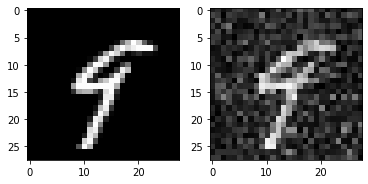

25  :  -0.9801434564032532 25
50  :  -0.937284726671761 25
75  :  -0.9150014569072871 25
100  :  -0.8635706503055041 25
125  :  -0.8443471448871325 25
150  :  -0.8443471448871325 25
175  :  -0.8266527058415756 25
200  :  -0.8266527058415756 25
225  :  -0.8224127817848363 25
250  :  -0.8266527058415756 25
275  :  -0.8233765744023565 25
300  :  -0.7914216892489214 25
325  :  -0.7889429156686207 25
350  :  -0.7805880922816499 25
375  :  -0.7805880922816499 25
400  :  -0.7805880922816499 25
425  :  -0.7687153158248634 25
450  :  -0.7328984289674463 25
475  :  -0.7328984289674463 25
500  :  -0.7328984289674463 25
525  :  -0.7328984289674463 25
550  :  -0.7087641153786988 25
575  :  -0.7024989487823268 25
600  :  -0.7035551118656416 25
625  :  -0.6880144631030094 25
650  :  -0.6864141652084639 25
675  :  -0.6737255101607751 25
700  :  -0.668194164065137 25
725  :  -0.663792524045153 25
750  :  -0.6570764865927774 25
775  :  -0.6540980164772239 25
800  :  -0.6540980164772239 25
825  :  -0.654

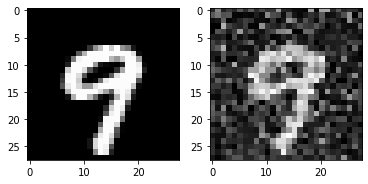

25  :  -0.7372193773770657 25
50  :  -0.7372193773770657 25
75  :  -0.7367656070134339 25
100  :  -0.7324017038865049 25
125  :  -0.7032861920356759 25
150  :  -0.6449715204618311 25
175  :  -0.6306898868856079 25
200  :  -0.6306898868856079 25
225  :  -0.6283812409675174 25
250  :  -0.5919978507857344 25
275  :  -0.5719388575176843 25
300  :  -0.5714848760423199 25
325  :  -0.5714848760423199 25
350  :  -0.5714848760423199 25
375  :  -0.5501536132385925 25
400  :  -0.5383806875482136 25
425  :  -0.5384750530486511 25
450  :  -0.5384750530486511 25
475  :  -0.5384750530486511 25
500  :  -0.5384750530486511 25
525  :  -0.5382646133158631 25
550  :  -0.535492064684707 25
575  :  -0.5153109064268793 25
600  :  -0.5098183009526138 25
625  :  -0.5028191791494089 25
650  :  -0.4997767311634306 25
675  :  -0.48303276574822607 25
700  :  -0.4823150568870844 25
725  :  -0.4764116336520058 25
750  :  -0.47222841899656876 25
775  :  -0.4721620501957261 25
800  :  -0.4649738537069189 25
825  :  -0

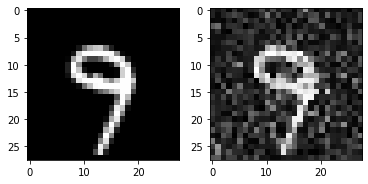

25  :  -0.6528035756740975 25
50  :  -0.6360538503887947 25
75  :  -0.6528035756740975 25
100  :  -0.5662847340754665 25
125  :  -0.5481015595858905 25
150  :  -0.5082577090540659 25
175  :  -0.5087854230231423 25
200  :  -0.5001837189160692 25
225  :  -0.4953131153811663 25
250  :  -0.49855261482572744 25
275  :  -0.49764630025295287 25
300  :  -0.4877847393635705 25
325  :  -0.4675048517810536 25
350  :  -0.4672297029641088 25
375  :  -0.4494864427669124 25
400  :  -0.4370741296551719 25
425  :  -0.4370741296551719 25
450  :  -0.4347824577628904 25
475  :  -0.4348733515139158 25
500  :  -0.432034837121554 25
525  :  -0.42793249089410546 25
550  :  -0.42582394707445115 25
575  :  -0.4187758071566978 25
600  :  -0.41323205995114687 25
625  :  -0.41327858631711856 25
650  :  -0.4071907361162638 25
675  :  -0.4060544793145108 25
700  :  -0.40021319135991307 25
725  :  -0.40063484715542896 25
750  :  -0.39653165709512916 25
775  :  -0.39646015367298726 25
800  :  -0.395754939466762 25
825

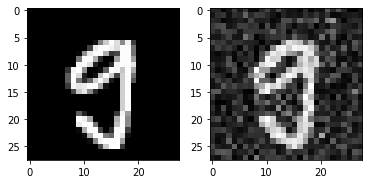

25  :  -0.7765637406757948 25
50  :  -0.7765637406757948 25
75  :  -0.7318583204649232 25
100  :  -0.7318583204649232 25
125  :  -0.7318583204649232 25
150  :  -0.7318583204649232 25
175  :  -0.7069184438840439 25
200  :  -0.7037576204851519 25
225  :  -0.7037576204851519 25
250  :  -0.7037576204851519 25
275  :  -0.7037576204851519 25
300  :  -0.7037576204851519 25
325  :  -0.7037576204851519 25
350  :  -0.7037576204851519 25
375  :  -0.7037576204851519 25
400  :  -0.7037576204851519 25
425  :  -0.6927615698945699 25
450  :  -0.6925367356113226 25
475  :  -0.6706400979354583 25
500  :  -0.6670010504239507 25
525  :  -0.6433373898810273 25
550  :  -0.6431554081438344 25
575  :  -0.6431554081438344 25
600  :  -0.6431554081438344 25
625  :  -0.6269697901966174 25
650  :  -0.6074486100006573 25
675  :  -0.6074486100006573 25
700  :  -0.6046458094200995 25
725  :  -0.6064446616632573 25
750  :  -0.5993285353518549 25
775  :  -0.5993285353518549 25
800  :  -0.5993285353518549 25
825  :  -0.

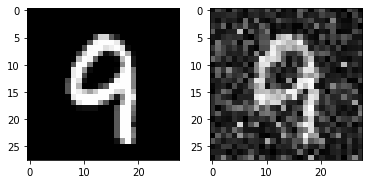

25  :  -0.780373942475576 25
50  :  -0.780373942475576 25
75  :  -0.780373942475576 25
100  :  -0.780373942475576 25
125  :  -0.7700695654956484 25
150  :  -0.8490734211491324 25
175  :  -0.7645747583267652 25
200  :  -0.7520054001784466 25
225  :  -0.7520054001784466 25
250  :  -0.7520054001784466 25
275  :  -0.7122680947841331 25
300  :  -0.7138215583238101 25
325  :  -0.7138215583238101 25
350  :  -0.7138215583238101 25
375  :  -0.7138215583238101 25
400  :  -0.7138215583238101 25
425  :  -0.7138215583238101 25
450  :  -0.6727242624855672 25
475  :  -0.6727242624855672 25
500  :  -0.6727242624855672 25
525  :  -0.6727242624855672 25
550  :  -0.6727242624855672 25
575  :  -0.6584265492614803 25
600  :  -0.6771420510915485 25
625  :  -0.6389991620981383 25
650  :  -0.6397649176183231 25
675  :  -0.6397649176183231 25
700  :  -0.6397649176183231 25
725  :  -0.6397649176183231 25
750  :  -0.6397649176183231 25
775  :  -0.6397649176183231 25
800  :  -0.6284368780744303 25
825  :  -0.6284

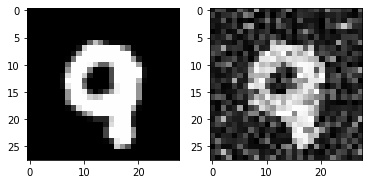

In [0]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28,28,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_cnn_mnist', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [0]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

112.27063250541687
39.084885597229004
71.22487594400134
10.389710470525127


In [0]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

2373
800
1455.5079365079366
218.49182709758372


In [0]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

15.784988789383252
11.18826117241262
13.57339850259419
1.0944907833914947
